In [1]:
from __future__ import print_function

from collections import defaultdict, deque
import datetime
import pickle
import time
import torch.distributed as dist
import errno

import collections
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from dataset import SIIM_MaskRCNN_Dataset
from util import mask2rle, rle2mask, dice

ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
# const

data_path = '../../data/siim-pneumothorax/'


## helpers

In [3]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)
    

In [4]:
def train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(train_data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    
    # TODO : save checkpoint
    torch.save(model_ft.state_dict(), "mrcnn_{}.pth".format(epoch))
        

In [5]:
dataset_train = SIIM_MaskRCNN_Dataset(
    os.path.join(data_path, "train-rle.csv"),
    os.path.join(data_path, 'train_png'),
    os.path.join(data_path, 'SIIM_5-FOLD_POS'),
    fold=0,
    phrase='train'
)


100%|██████████| 11582/11582 [00:00<00:00, 12000.96it/s]


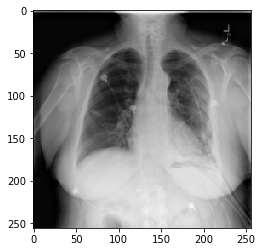

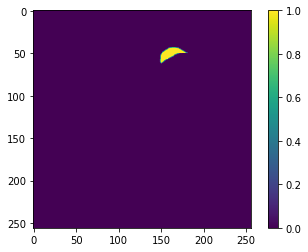

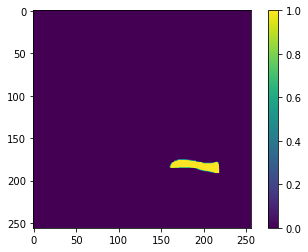

In [6]:
# let's load and watch some sample

for data in dataset_train:
    img, target = data
    
    if target['masks'].shape[0] > 1:
        plt.imshow(img.numpy().transpose((1, 2, 0)))
        plt.show()
        
        for mask in target['masks']:
            plt.imshow(mask)
            plt.colorbar()
            plt.show()
        
        break


In [7]:
# create mask rcnn model
num_classes = 2
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    box_nms_thresh=0.05,
)

# re-init box predictor
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# re-init mask predictor
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = True
    

In [8]:
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=lambda x: tuple(zip(*x)))


In [9]:
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)


In [10]:
num_epochs = 12
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()
    

Epoch: [0]  [  0/476]  eta: 0:11:04  lr: 0.000003  loss: 2.2747 (2.2747)  loss_classifier: 1.0202 (1.0202)  loss_box_reg: 0.0214 (0.0214)  loss_mask: 1.0916 (1.0916)  loss_objectness: 0.1277 (0.1277)  loss_rpn_box_reg: 0.0137 (0.0137)  time: 1.3952  data: 0.6074  max mem: 6085
Epoch: [0]  [100/476]  eta: 0:03:23  lr: 0.000213  loss: 0.7298 (1.0894)  loss_classifier: 0.1194 (0.2682)  loss_box_reg: 0.0620 (0.0587)  loss_mask: 0.4393 (0.6313)  loss_objectness: 0.0551 (0.1157)  loss_rpn_box_reg: 0.0115 (0.0156)  time: 0.5468  data: 0.0049  max mem: 8102
Epoch: [0]  [200/476]  eta: 0:02:40  lr: 0.000424  loss: 0.5951 (0.8854)  loss_classifier: 0.1160 (0.1966)  loss_box_reg: 0.0774 (0.0682)  loss_mask: 0.3599 (0.5230)  loss_objectness: 0.0363 (0.0834)  loss_rpn_box_reg: 0.0082 (0.0143)  time: 0.6764  data: 0.0049  max mem: 8153
Epoch: [0]  [300/476]  eta: 0:01:49  lr: 0.000634  loss: 0.6452 (0.7967)  loss_classifier: 0.1168 (0.1707)  loss_box_reg: 0.0839 (0.0732)  loss_mask: 0.3772 (0.4749) 

Traceback (most recent call last):
  File "/home/voyager/anaconda3/envs/siim/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/voyager/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/voyager/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/voyager/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/voyager/anaconda3/envs/siim/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/voyager/anaconda3/envs/siim/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/ho

KeyboardInterrupt: 

In [ ]:
torch.save(model_ft.state_dict(), "mrcnn-model.bin")


## eval

In [4]:
# const

model_path = 'mrcnn_5.pth'
image_size = 256

In [5]:
dataset_val = SIIM_MaskRCNN_Dataset(
    os.path.join(data_path, "train-rle.csv"),
    os.path.join(data_path, 'train_png'),
    os.path.join(data_path, 'SIIM_5-FOLD_POS'),
    fold=0,
    phrase='val'
)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=lambda x: tuple(zip(*x)))

100%|██████████| 11582/11582 [00:00<00:00, 12050.29it/s]


In [6]:
# create mask rcnn model
num_classes = 2
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    box_nms_thresh=0.1,
    box_detections_per_img=4,
)

# re-init box predictor
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# re-init mask predictor
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model_ft.load_state_dict(torch.load(model_path))
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [7]:
def merge_mask(masks):
    mask = np.amax(masks, axis=0)

    return mask

In [24]:
# find out best score_threshold
score_thres_start = 0.01
score_thres_end = 1
score_thres_step = 0.01

score_thresholds = np.arange(0.01, 1, 0.01)
dice_list = []

result_list = []

with torch.no_grad():
    with tqdm(total=len(val_data_loader)) as pbar:
        for images, targets in val_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            results = model_ft(images)
            
            # apply score_thresholds
            for score_threshold in score_thresholds:
                dices = []
                masks = []
                
                for i, result in enumerate(results):
                    sample_masks = []
                    
                    for score, mask in zip(result['scores'], result['masks']):
                        if score > score_threshold:
                            sample_masks.append(mask.cpu().numpy().squeeze())
                    
                    if len(sample_masks) > 0:
                        sample_mask = merge_mask(sample_masks)
                    else:
                        sample_mask = np.zeros_like(targets[0]['masks'].cpu().numpy()[0].squeeze())
                        
                    masks.append(sample_mask)
                    # [print(mask.shape) for mask in masks]
                    
                metric = dice(
                    torch.from_numpy(np.stack(masks)).squeeze(),
                    torch.stack([torch.from_numpy(merge_mask(target['masks'].cpu().numpy())) for target in targets]).squeeze()
                )
        
                dices.append(metric)
            dice_list.append(np.mean(dices))
            
            pbar.update(1)


100%|██████████| 119/119 [00:48<00:00,  2.42it/s]


In [26]:
print(dice_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:




dice_list = np.array(dice_list)

best_dice = dice_list.max()
best_thr = score_thresholds[dice_list.argmax()]

plt.figure(figsize=(8,4))

plt.plot(score_thresholds, dice_list)
plt.vlines(x=best_thr, ymin=dice_list.min(), ymax=dice_list.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);

plt.show()


TypeError: unsupported operand type(s) for +: 'function' and 'function'

## test

In [30]:
# const

model_path = 'mrcnn_5.pth'
image_size = 256

In [31]:
test_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
test_df = test_df.drop_duplicates('ImageId', keep='last').reset_index(drop=True)

# create mask rcnn model
num_classes = 2
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    box_nms_thresh=0.03,
    box_detections_per_img=4,
)

# re-init box predictor
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# re-init mask predictor
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model_ft.load_state_dict(torch.load(model_path))
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    


  0%|          | 0/1372 [00:00<?, ?it/s]

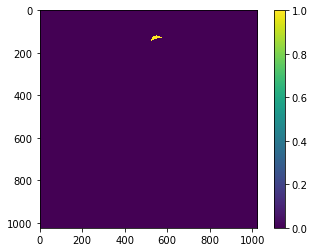

rle  122400 4 1016 14 1008 18 1004 21 1002 24 998 29 993 33 990 36 987 39 984 42 981 47 976 49 974 36 3 11 974 29 994 24 999 19 1005 17 1006 17 1007 15 1008 13 1011 11 1013 10 57 2 954 9 58 4 953 7 62 2 954 3


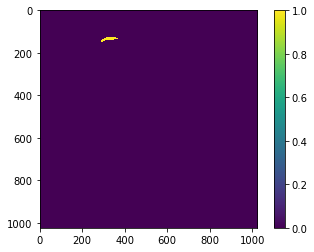

rle  128333 6 1008 25 995 33 987 40 979 48 974 52 970 56 964 62 959 68 954 72 951 72 950 72 950 60 5 5 953 55 969 29 994 23 1000 22 1001 20 1004 16 1007 15 1008 14 1010 13 1011 9 1015 7 1018 5


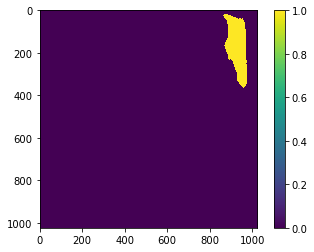

rle  21353 1 1015 19 1003 24 999 27 997 30 993 34 990 36 989 37 987 38 986 41 983 44 981 45 979 47 977 50 974 53 972 55 969 57 968 58 967 59 16 1 8 1 940 63 7 6 6 3 940 64 4 8 4 5 940 64 2 10 2 7 940 85 941 83 942 82 943 82 943 81 943 81 944 81 944 80 944 80 944 81 944 80 944 81 943 81 943 82 943 81 943 82 942 82 942 82 943 82 942 82 942 82 942 82 943 81 943 82 942 82 942 82 943 81 943 81 943 81 943 81 943 81 943 81 944 80 944 81 943 81 943 81 943 81 943 81 943 81 943 81 943 82 943 81 943 81 943 81 943 81 943 81 943 81 943 81 943 81 943 82 942 82 942 82 941 83 941 83 941 83 941 83 941 83 941 83 941 84 940 84 940 84 940 84 940 84 940 84 940 84 941 83 941 83 941 83 941 83 941 84 940 84 940 84 940 84 940 84 939 85 939 85 939 85 939 85 939 85 938 86 938 86 938 86 938 86 937 87 937 87 937 87 937 87 937 87 936 88 936 88 936 88 935 89 935 89 935 89 934 90 934 90 934 90 933 91 933 91 933 91 932 92 932 92 931 93 930 94 930 94 929 95 928 96 927 97 927 97 927 97 926 98 926 98 926 98 925 99 925 99

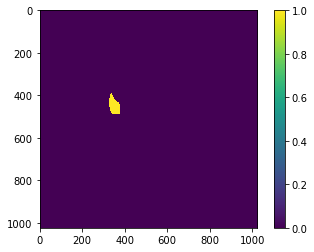


  0%|          | 1/1372 [00:01<40:56,  1.79s/it]

rle  397646 1 1022 3 1021 4 1019 6 1018 6 1018 7 1016 8 1016 9 1015 9 1014 10 1014 11 1013 11 1012 12 1012 13 1011 13 1011 14 1010 14 1010 15 1008 16 1008 17 1007 17 1006 19 1005 19 1005 19 1005 20 1003 21 1003 21 1003 22 1002 22 1001 23 1001 24 1000 24 1000 25 998 26 998 27 997 28 996 29 995 31 992 33 991 34 990 39 985 40 984 40 984 41 983 42 982 44 980 46 978 47 977 48 976 49 975 49 975 50 975 50 974 51 973 51 973 51 973 52 972 52 972 52 973 51 973 52 972 52 972 52 973 51 973 51 973 51 974 50 974 51 973 51 973 51 973 51 974 50 974 50 974 50 975 49 975 49 975 49 975 49 976 48 976 48 976 48 976 48 977 47 977 47 977 46 979 45 979 45 979 45 980 44 980 43 981 43 982 42 982 42 983 41 983 41 984 39 986 38 987 36 990 34 992 31 996 26 1001 22


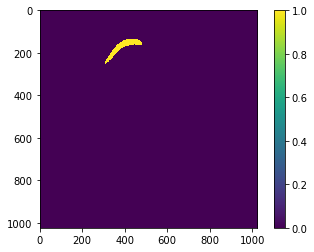

rle  138660 30 986 43 976 52 968 58 962 64 957 69 953 72 950 76 947 78 944 81 941 85 937 88 934 92 930 95 927 98 924 101 922 102 921 103 920 104 919 105 918 106 916 108 915 109 914 110 912 112 911 113 910 114 909 77 6 32 908 72 29 13 909 69 37 7 910 67 956 58 966 54 969 51 972 48 975 47 976 46 977 45 978 44 979 43 980 42 981 41 982 40 984 37 986 36 987 35 988 35 988 35 988 35 989 34 989 33 991 32 991 32 991 32 992 31 992 31 992 30 993 30 994 29 994 29 994 29 995 28 995 28 995 28 996 27 996 27 997 26 997 26 997 26 998 26 997 26 997 26 997 26 998 25 998 25 998 25 999 24 999 24 999 24 1000 23 1000 24 999 24 1000 23 1000 24 1000 23 1000 23 1000 24 1000 23 1000 23 1000 23 1001 22 1001 22 1001 23 1000 22 1001 22 1002 21 1002 21 1002 22 1001 22 1002 21 1002 20 1004 19 1005 17 1006 17 1007 16 1008 15 1008 16 1007 16 1008 14 1009 14 1009 14 1010 13 1011 12 1012 11 1012 11 1013 9 1015 7 1017 5 1019 5 1020 3


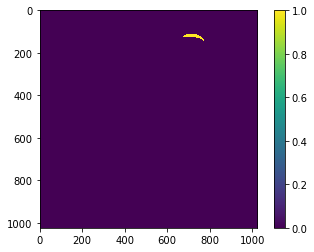

rle  114367 17 998 30 990 39 982 45 976 52 970 57 964 64 958 68 954 72 950 76 947 79 944 82 942 83 940 85 938 28 22 38 936 17 37 35 935 15 42 33 998 26 1000 25 1002 23 1006 19 1010 15 1012 14 1013 12 1014 11 1015 10 1015 10 1014 11 1014 11 1014 10 1014 11 1015 9 1017 7 1020 5 1021 4 1023 1


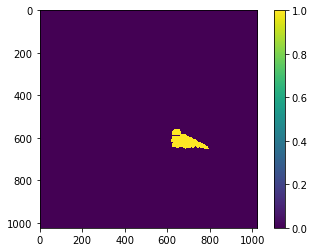

rle  573060 8 1004 22 1000 26 997 27 996 29 994 31 992 32 991 34 989 35 988 37 986 38 986 38 986 38 986 39 985 39 985 39 985 39 985 39 985 39 985 39 985 39 985 40 984 42 982 45 978 49 7 6 962 64 960 67 957 69 956 68 958 66 967 2 21 35 987 38 957 70 951 74 949 77 946 79 945 80 945 80 944 89 935 91 934 91 936 89 940 85 935 91 926 99 922 104 918 107 4 6 907 118 906 118 907 118 907 118 906 118 906 119 904 121 903 122 902 123 901 124 900 125 899 127 898 130 895 133 893 134 893 133 892 135 887 139 884 143 880 145 879 147 878 148 876 150 874 152 872 154 871 154 870 155 869 156 869 156 868 156 868 157 867 6 4 148 866 6 5 149 864 7 2 152 863 163 861 106 5 55 860 5 1 97 7 56 869 91 9 55 871 20 11 57 11 13 1 41 872 12 22 36 7 7 15 7 7 39 873 8 27 29 50 38 873 4 31 24 56 36 910 17 64 34 910 11 71 33 911 4 86 23 1005 18 1008 15 1010 13 1015 2


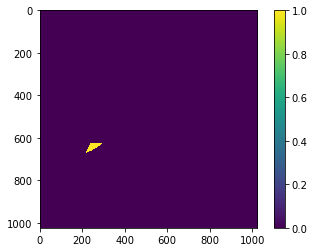


  0%|          | 2/1372 [00:03<40:16,  1.76s/it]

rle  637217 4 990 5 21 9 979 20 2 23 973 51 970 54 967 55 968 55 967 56 967 56 968 55 968 55 969 53 971 52 971 50 974 49 975 47 977 45 978 44 979 43 981 42 981 42 982 41 982 41 983 40 983 40 984 38 985 37 986 37 987 35 989 34 989 33 991 31 993 29 994 28 995 27 996 26 998 24 999 23 1000 21 1003 19 1004 18 1005 17 1007 15 1008 14 1010 12 1012 11 1013 9 1015 7 1018 3


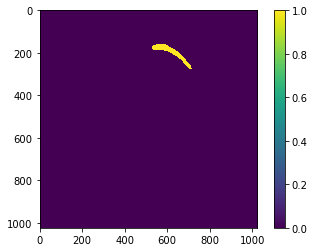

rle  162355 5 8 3 1001 26 991 36 984 43 979 47 974 53 969 57 963 63 959 67 955 71 952 74 949 77 946 79 945 81 942 84 940 85 939 87 937 89 935 91 933 93 931 95 929 96 928 98 927 99 925 101 924 101 923 103 922 104 921 104 926 25 9 66 927 13 25 61 928 2 37 59 967 58 969 57 970 55 973 52 982 44 982 43 982 43 983 42 984 42 984 41 984 41 985 40 986 39 986 39 987 38 987 38 988 36 989 36 990 36 989 36 990 35 991 34 992 33 993 33 993 32 993 32 994 31 995 29 997 28 997 28 998 27 998 26 999 26 999 26 999 26 999 26 999 26 1000 25 1000 24 1002 23 1002 23 1003 22 1003 22 1003 22 1003 22 1002 23 1002 23 1002 22 1003 22 1003 22 1003 22 1003 22 1003 22 1002 23 1001 24 1001 23 1002 23 1002 23 1002 23 1001 24 1001 24 1001 23 1002 23 1001 24 1001 23 1002 23 1002 23 1001 24 1001 23 1003 22 1004 21 1004 20 1005 20 1004 20 1005 20 1005 19 1005 19 1006 19 1006 18 1007 18 1007 17 1009 15 1011 13 1014 11 1014 10 1015 9 1016 8 1017 6


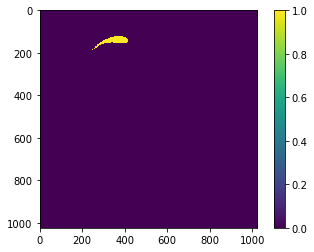

rle  124272 5 1012 25 991 35 983 44 975 52 968 58 962 65 955 71 950 76 946 79 943 83 938 87 935 90 931 94 927 98 923 102 920 105 917 107 915 110 912 112 910 115 907 117 905 119 903 121 901 123 900 124 899 125 897 126 897 126 897 126 896 126 897 51 8 66 897 38 65 10 3 8 898 36 987 31 993 25 998 23 1000 22 1001 20 1003 18 1004 18 1005 17 1006 15 1008 14 1009 14 1009 13 1010 13 1009 13 1009 14 1009 14 1010 13 1010 13 1011 12 1011 12 1012 10 1013 9 1014 9 1013 10 1013 9 1014 8 1013 10 1012 11 1012 10 1014 8 1015 6 1018 4 1021 1


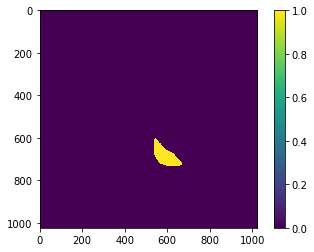


  0%|          | 3/1372 [00:04<36:51,  1.62s/it]

rle  615965 2 1021 4 1020 5 1018 6 1018 7 1016 8 1016 9 1014 11 1012 13 1011 13 1011 15 1009 18 1006 19 1004 20 1005 20 1004 20 1004 21 1002 23 1001 23 1001 24 1000 24 1000 25 999 26 998 28 996 30 994 31 993 32 992 32 992 33 991 33 990 35 989 36 988 36 988 38 986 40 984 41 983 42 982 43 981 43 981 44 980 44 980 45 979 46 978 47 977 48 977 49 975 51 973 52 972 53 971 54 970 54 970 55 969 55 969 56 968 58 966 59 965 62 963 62 962 63 961 64 960 65 959 65 959 67 957 75 949 83 941 85 939 86 938 86 939 85 939 86 938 87 937 88 936 90 934 91 933 94 930 95 929 95 929 96 929 95 930 94 931 93 931 93 931 94 930 95 929 97 927 98 927 99 925 100 924 101 924 100 925 99 925 100 925 99 926 98 926 99 925 100 925 100 924 103 922 103 921 104 921 104 920 105 920 104 921 104 921 104 922 103 922 103 922 103 921 105 919 106 918 107 917 108 916 109 916 108 916 109 916 108 917 108 917 107 918 106 920 104 924 100 925 99 926 98 928 97 935 89 940 83 945 78 948 75 950 73 955 63 967 46 1 4 986 20


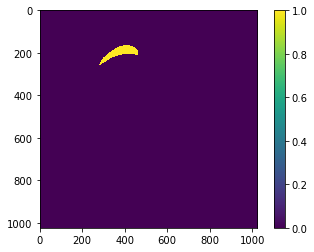

rle  169355 20 998 34 983 43 977 50 971 56 966 60 962 64 958 68 955 71 951 74 948 78 943 83 939 87 935 90 933 92 930 95 928 97 926 99 924 101 921 104 918 107 916 109 912 113 909 115 907 118 905 120 903 121 901 124 899 125 898 127 895 129 893 132 891 133 890 135 887 137 885 139 884 140 883 141 882 142 881 143 880 144 879 84 25 35 879 80 44 21 877 76 54 16 877 72 63 11 877 69 72 2 880 63 960 60 963 57 966 56 967 54 969 53 970 51 972 49 974 47 976 45 977 44 979 42 981 40 983 39 985 36 987 36 987 35 989 33 990 33 990 33 990 32 992 30 993 30 993 29 994 28 996 27 996 26 997 26 998 24 999 24 999 23 1001 22 1001 21 1002 21 1002 21 1003 20 1003 19 1005 18 1006 15 1009 14 1009 13 1011 12 1012 11 1012 10 1014 8 1016 7 1016 8 1016 7 1018 5 1020 3


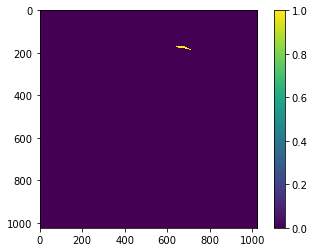

rle  172684 7 4 3 1001 28 992 37 986 41 982 44 977 50 974 53 981 45 984 42 990 36 998 28 1002 25 1006 19 1008 18 1012 14 1013 11 1017 10 1019 7 1018 6 1021 3 2049 2


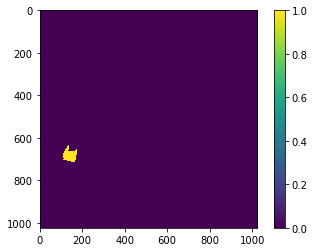


  0%|          | 4/1372 [00:06<34:44,  1.52s/it]

rle  651394 5 1019 5 1018 6 1018 6 1017 7 1016 8 1016 8 1015 8 1015 9 1015 9 1014 10 1012 12 1011 13 1011 13 1010 15 1009 15 38 2 968 16 36 4 968 16 35 6 967 16 34 7 966 16 35 6 967 15 35 7 966 15 35 8 966 15 34 9 965 17 32 10 965 18 1 6 2 4 17 11 964 34 13 13 964 60 963 61 963 61 962 62 962 62 961 62 962 62 961 62 961 63 961 62 961 63 961 63 961 63 960 64 960 64 959 65 959 65 958 65 959 65 959 65 959 64 960 64 960 64 960 64 960 64 960 64 960 64 960 64 960 64 961 63 962 61 965 59 965 59 965 59 966 57 967 57 967 57 967 57 966 57 967 57 967 57 969 54 970 54 971 3 4 46 985 39 986 37 988 36 989 3 1 30 998 25 1005 19 1010 12


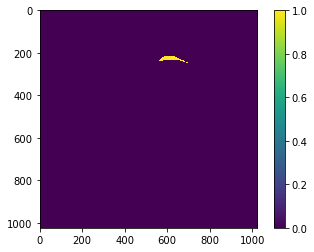

rle  220761 7 1007 31 988 44 976 50 972 55 967 59 963 63 959 67 956 71 951 75 948 78 945 81 942 83 940 86 936 91 931 95 928 98 926 101 922 58 14 33 919 41 39 26 917 29 57 22 916 25 66 19 913 21 77 19 907 7 97 14 908 3 106 8 1017 8 1017 9 1017 7 1 5 1021 5 1019 7 1017 9 1016 9 1017 6


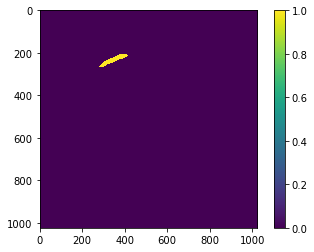

rle  212357 7 1005 24 996 35 987 39 983 42 979 45 976 49 973 51 971 52 970 54 968 55 967 56 966 58 964 59 962 61 960 56 966 57 964 59 962 60 962 60 962 58 963 57 964 58 964 59 963 58 963 55 967 54 968 54 968 55 967 53 969 52 970 52 970 52 970 53 970 52 970 52 970 50 973 49 974 48 975 47 976 46 977 46 977 45 978 44 979 42 981 37 986 36 988 34 989 33 990 32 991 32 992 30 993 30 993 29 994 28 996 25 998 24 1000 23 1000 22 1002 21 1004 16 1010 5


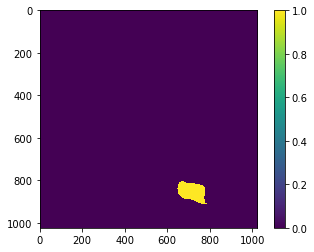


  0%|          | 5/1372 [00:07<33:06,  1.45s/it]

rle  823961 7 1013 14 1008 17 1006 20 1002 23 999 27 997 31 992 36 988 44 979 66 958 74 949 81 942 89 934 96 928 100 924 103 920 108 916 111 912 115 909 116 908 118 906 119 904 121 903 122 902 123 901 124 900 125 899 125 899 126 898 127 897 127 896 129 895 129 895 130 894 130 894 130 895 129 895 129 895 129 895 129 895 129 895 129 895 129 895 129 896 129 895 129 895 129 895 129 896 128 896 128 896 128 896 128 896 128 896 128 897 127 897 126 899 125 899 124 901 123 901 123 902 122 902 122 903 121 903 121 904 120 904 119 906 118 907 117 908 116 909 114 911 113 912 112 913 111 914 110 916 108 916 108 917 107 918 106 920 104 923 101 927 97 929 8 2 85 949 75 953 72 955 70 957 68 960 64 963 61 967 57 969 54 973 51 976 48 979 46 980 44 981 43 982 43 982 42 984 41 984 40 985 38 988 36 990 33 993 22 4 5 995 20 1 9 1003 11 1 11 1 4 998 27 999 6 2 17 1009 14 1012 5 4 3 5118 1 1023 1 1023 1 1023 1


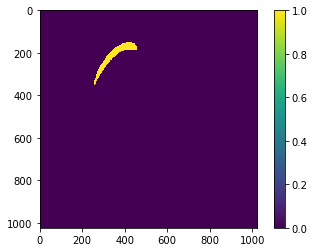

rle  152994 7 1014 14 1005 21 996 30 992 34 988 38 984 43 979 47 968 58 964 61 962 63 960 65 958 67 956 68 955 69 953 72 948 76 944 81 941 84 937 88 934 91 932 93 930 95 928 96 927 98 925 99 924 100 922 103 920 104 918 106 917 107 916 108 914 110 913 111 912 112 912 112 911 112 911 112 911 77 11 24 911 70 27 9 917 60 962 56 967 51 972 49 973 49 974 48 976 47 976 46 977 45 978 44 978 44 979 43 980 43 980 43 980 43 980 43 980 42 981 42 982 42 981 42 981 41 982 41 982 41 982 41 982 41 983 40 983 40 983 40 983 40 984 39 984 39 984 38 986 37 986 37 986 37 987 36 987 35 989 34 989 34 990 33 990 33 991 32 991 32 992 32 991 32 992 31 992 31 992 31 993 30 993 31 992 31 993 30 993 30 993 30 994 29 994 29 994 29 994 29 994 29 994 29 994 29 994 29 995 28 995 28 996 27 996 28 995 28 996 27 996 28 995 28 996 28 995 28 995 29 995 28 995 28 996 28 995 28 996 27 996 28 996 27 996 27 997 26 997 27 996 27 997 26 997 26 998 26 997 26 997 26 998 25 999 25 998 25 999 24 999 25 999 24 1000 23 1000 24 1000 23

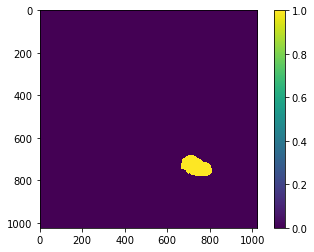

rle  699073 9 1007 26 994 32 990 36 986 39 983 42 981 45 977 49 973 53 969 57 966 60 963 63 960 65 957 68 955 71 952 74 950 75 948 78 945 81 942 83 940 85 939 86 937 89 935 91 932 93 931 94 930 95 929 95 928 98 926 100 924 103 920 109 915 112 912 116 908 120 904 123 901 125 898 127 897 129 894 131 893 132 892 134 890 135 889 137 887 138 885 140 883 141 883 142 882 142 882 143 882 142 883 141 883 141 883 142 881 143 880 144 880 144 881 143 882 143 882 142 882 142 882 142 882 143 880 144 881 143 885 139 889 135 892 133 893 131 899 125 900 123 902 122 903 121 903 121 903 121 904 120 904 120 904 120 905 119 906 118 906 117 908 116 909 115 910 114 911 112 912 8 2 102 912 8 4 99 913 8 5 98 914 6 8 95 931 91 934 88 937 82 944 78 948 75 956 66 961 61 978 3 10 3 10 7


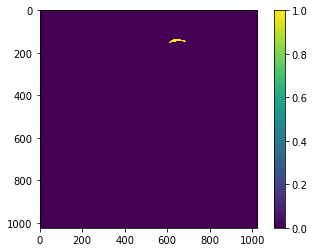

rle  138877 7 1010 24 996 33 989 39 983 44 978 49 973 56 966 61 963 63 959 67 956 72 951 28 23 24 948 26 33 17 947 24 42 12 944 19 55 7 943 16 61 5 941 15 1009 7 1016 3


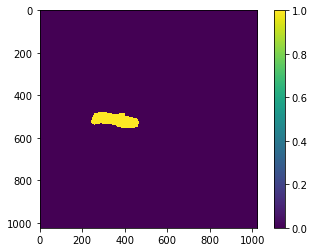


  0%|          | 6/1372 [00:09<34:37,  1.52s/it]

rle  491807 15 1 8 987 40 981 46 975 56 961 69 61 3 887 77 44 18 883 85 33 24 881 93 21 30 880 97 6 41 879 146 877 147 877 148 875 149 875 149 874 151 873 151 872 153 871 156 2 4 861 165 859 167 856 171 853 183 841 185 838 189 835 191 833 200 823 205 819 208 816 210 813 213 811 214 809 216 808 216 808 217 806 219 805 219 804 221 803 221 803 221 802 222 802 223 801 223 800 224 800 224 800 224 800 224 800 224 800 224 800 224 801 223 801 223 802 222 802 222 803 39 12 170 806 21 6 3 26 2 10 12 2 136 809 15 54 2 12 132 811 11 72 129 818 3 78 125 905 119 908 116 911 113 914 110 917 107 918 105 921 102 923 100 926 98 929 95 931 92 935 88 942 80 948 68 958 63 963 59 969 17 11 14 3 8


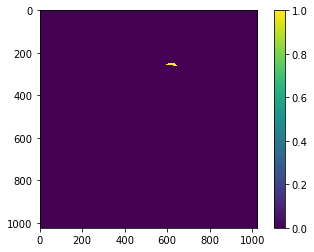

rle  254560 16 1005 23 998 29 993 32 991 35 987 40 982 44 980 45 977 48 975 50 973 52 974 3 5 1 16 26 1006 19 1010 16 1010 14 1021 2


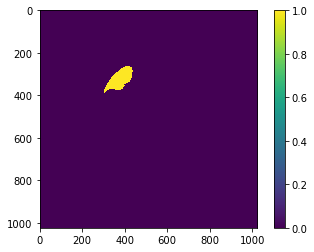

rle  269720 7 1010 18 1004 24 997 29 992 34 988 37 985 40 983 42 981 44 978 47 975 50 973 51 972 53 970 54 969 55 968 56 967 57 966 58 965 59 963 62 961 63 960 64 959 65 958 66 957 67 956 68 954 70 952 72 950 73 948 76 947 77 946 78 945 79 944 80 944 80 943 81 942 82 941 83 940 84 938 86 937 87 936 87 936 88 936 88 935 89 934 90 934 90 933 91 932 91 932 92 931 93 930 94 929 94 929 95 928 96 928 96 927 96 927 97 927 96 927 97 926 97 927 97 926 97 927 97 926 97 926 97 927 96 927 96 927 97 927 97 926 98 925 99 924 99 924 100 923 100 924 97 926 97 927 95 928 94 929 93 931 91 932 90 934 88 935 86 937 84 940 82 941 82 942 82 941 83 940 85 939 85 939 85 938 85 938 85 939 85 938 85 938 86 938 85 938 86 937 86 938 86 937 87 937 87 936 88 936 87 937 87 936 87 937 34 1 50 938 28 11 43 942 23 26 31 943 23 29 27 945 22 40 8 5 3 946 21 43 3 957 19 1004 18 1006 16 1008 15 1009 13 1011 12 1011 12 1012 11 1013 10 1013 10 1014 9 1016 8 1017 6 1019 4


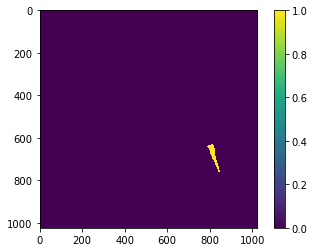

rle  645925 6 1015 11 1010 15 1003 22 1000 25 998 26 997 28 994 30 993 31 992 33 991 33 991 33 991 33 992 33 992 32 993 31 995 30 995 29 996 29 996 28 996 29 995 29 996 28 996 28 997 27 998 26 998 26 998 26 999 25 1000 24 1000 24 1001 23 1001 23 1001 23 1001 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1001 23 1002 22 1003 21 1003 22 1002 22 1003 21 1003 21 1004 20 1004 20 1005 19 1005 19 1005 19 1005 19 1006 19 1005 19 1006 18 1006 18 1007 18 1006 19 1005 19 1006 18 1006 19 1005 19 1006 18 1006 18 1007 17 1008 17 1007 17 1008 16 1008 16 1009 16 1008 16 1009 16 1008 16 1009 15 1009 15 1010 15 1009 15 1010 14 1010 14 1011 13 1011 13 1012 12 1012 12 1013 11 1013 12 1013 11 1013 12 1013 12 1013 11 1013 11 1013 12 1013 11 1013 11 1013 11 1014 11 1013 11 1013 11 1014 11 1013 11 1013 11 1014 11 1013 11 1014 10 1014 11 1014 10 1014 10 1015 9 1015 10 1015 9 1015 9 1016 8 1016 8 1017 8 1016 8 1017 7 1017 8 1016 8 1016 8 1016 9 1016 8 1016 8 1016 8 1017 7 1017 7 101

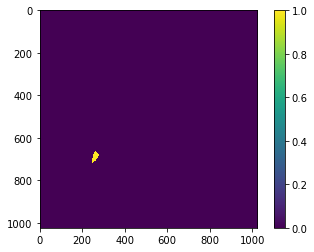


  1%|          | 7/1372 [00:10<35:58,  1.58s/it]

rle  679169 6 1018 7 1016 9 1015 10 1013 12 1011 15 1009 16 1007 18 1006 19 1005 20 1003 22 1002 22 1002 23 1000 25 999 25 999 25 999 25 998 27 997 27 997 27 996 27 997 27 997 26 998 26 997 26 998 25 999 25 999 24 999 24 1000 24 1000 23 1001 22 1002 21 1002 22 1002 21 1003 21 1003 20 1004 19 1005 19 1004 19 1005 18 1006 17 1007 17 1007 16 1008 15 1009 14 1010 13 1011 12 1012 11 1013 10 1014 9 1015 7 1018 5 1019 1


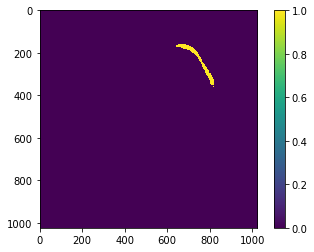

rle  162447 23 999 27 994 32 989 37 986 41 982 46 976 53 970 57 966 61 963 63 960 65 958 68 956 70 955 71 954 72 953 72 967 59 969 56 970 56 970 55 971 54 973 52 974 51 976 49 978 48 980 45 983 42 987 38 990 35 993 32 994 31 995 31 994 30 995 30 995 30 996 28 997 28 997 28 997 27 998 27 998 26 999 26 1000 25 1001 23 1004 21 1005 20 1006 19 1006 18 1008 17 1007 17 1008 17 1008 16 1009 16 1008 16 1009 15 1010 15 1009 15 1010 15 1010 15 1010 14 1011 14 1011 14 1012 12 1013 12 1013 12 1012 13 1012 13 1011 14 1011 14 1010 14 1010 14 1011 14 1010 14 1010 14 1010 14 1010 14 1011 13 1011 14 1011 13 1011 13 1012 13 1012 12 1013 12 1013 12 1013 12 1013 13 1012 13 1011 13 1012 13 1011 14 1011 13 1011 14 1011 13 1011 14 1011 13 1011 14 1010 14 1011 14 1010 15 1009 15 1009 16 1009 15 1009 16 1008 17 1008 17 1007 18 1007 18 1006 18 1007 18 1006 18 1007 18 1006 18 1006 19 1006 18 1006 19 1006 18 1006 19 1006 18 1006 19 1006 19 1006 19 1005 20 1005 20 1005 19 1005 20 1005 20 1005 19 1005 20 1005 19 10

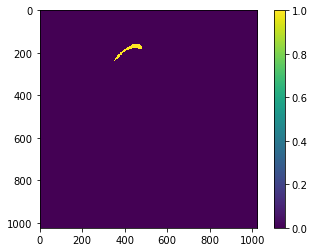

rle  163268 4 1008 21 999 32 989 37 986 39 983 42 980 46 976 49 973 51 971 54 968 57 966 59 963 61 961 63 959 65 957 68 955 69 953 71 952 72 950 74 949 32 19 24 948 29 26 21 946 28 32 18 945 24 45 10 944 22 1000 22 1001 21 1001 20 1003 18 1005 16 1006 17 1006 16 1007 16 1007 16 1006 17 1007 15 1008 14 1009 13 1009 14 1009 13 1009 14 1009 14 1009 15 1008 15 1008 14 1010 12 1011 12 1011 12 1010 15 1008 16 1006 18 1005 18 1005 18 1006 16 1007 14 1008 16 1008 16 1007 17 1007 18 1005 18 1006 16 1007 14 1009 13 1010 13 1011 13 1010 13 1010 14 1009 14 1009 12 1012 11 1012 11 1012 11 1012 11 1013 9 1014 9 1015 7 1017 6 1018 4 1020 3 1021 2


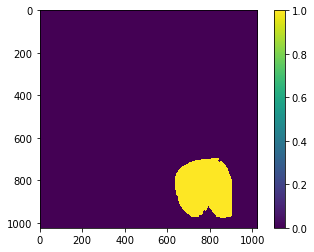

rle  713513 5 1015 37 984 40 959 65 949 75 945 78 940 84 933 90 927 96 919 105 912 111 909 115 906 118 903 121 900 124 11 2 885 127 8 7 880 130 5 10 877 133 2 14 871 154 867 159 863 162 861 164 859 165 858 167 856 168 855 170 852 173 849 175 847 178 844 181 841 184 838 187 835 190 832 193 829 196 827 197 826 199 823 202 821 203 819 206 817 208 815 210 813 211 811 214 809 216 807 218 805 219 804 221 802 223 800 224 799 226 796 228 795 229 793 232 791 233 790 234 789 236 788 236 787 237 787 237 787 237 786 239 785 239 784 240 784 240 783 242 782 242 782 243 780 244 779 245 779 246 777 247 776 249 774 250 774 251 772 252 771 254 770 254 769 256 768 256 768 256 768 257 766 258 766 259 764 260 764 260 764 260 763 262 762 262 762 262 762 263 761 263 761 264 760 264 759 266 758 266 758 267 757 267 757 268 756 268 756 268 756 268 756 269 754 270 754 270 754 270 754 270 754 270 754 271 753 271 753 271 753 271 753 271 753 271 753 271 754 270 754 270 754 271 753 271 753 271 753 271 752 272 752 27

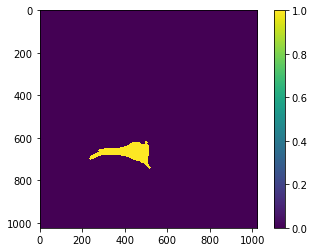


  1%|          | 8/1372 [00:12<36:32,  1.61s/it]

rle  630257 2 1021 4 1019 6 1017 8 963 4 15 4 29 10 959 11 8 10 25 12 955 33 24 12 952 37 22 14 949 40 21 13 949 42 21 12 947 45 20 11 947 47 19 11 946 50 17 11 944 54 14 12 942 58 12 11 942 62 7 14 939 87 935 91 931 94 928 97 924 101 921 103 918 107 915 109 913 111 911 113 908 116 905 119 902 122 897 127 891 133 883 142 866 158 821 29 6 168 814 211 810 214 805 219 796 228 794 230 792 232 790 234 788 236 785 239 784 240 785 239 785 239 786 239 785 239 785 239 785 239 785 239 784 240 781 243 779 245 777 247 776 248 775 248 774 250 773 251 770 254 767 257 764 260 762 261 761 263 760 69 8 6 19 9 4 149 759 63 59 143 757 60 68 138 756 53 82 133 753 47 95 129 751 44 103 126 750 42 114 118 749 40 122 112 750 37 127 110 750 35 131 107 751 33 135 105 751 31 141 100 752 29 150 93 753 27 155 88 757 22 159 86 758 18 164 84 756 17 168 83 750 21 171 82 748 21 174 81 748 20 176 80 748 15 182 79 748 13 186 77 749 11 190 74 752 4 199 68 961 63 964 59 969 55 972 52 979 45 983 41 986 38 987 37 989 35 990

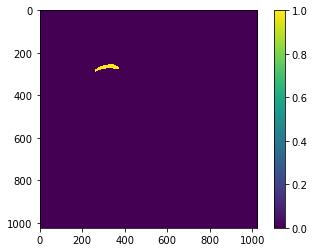

rle  261454 8 1002 27 987 41 977 51 969 57 963 63 958 67 955 70 951 75 946 79 943 83 939 86 936 89 933 91 930 95 927 98 924 101 922 102 920 48 21 36 918 44 35 27 917 40 50 17 916 36 59 12 915 34 66 8 915 30 993 28 995 26 997 23 1001 20 1003 19 1005 17 1007 13 1011 10 1014 8 1016 6 1018 3


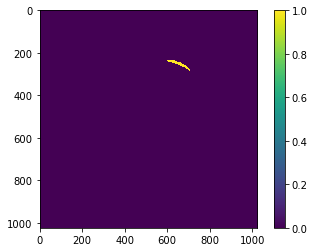

rle  241240 8 4 7 1003 28 995 37 987 40 985 42 983 43 983 44 983 44 983 44 984 43 985 43 984 43 983 43 984 42 986 40 986 39 989 36 992 34 994 31 997 29 998 27 998 27 999 27 999 27 1000 26 1001 25 1002 24 1002 23 1002 23 1003 22 1003 22 1004 21 1006 19 1007 19 1007 19 1007 18 1007 18 1007 18 1007 19 1007 18 1008 16 1009 16 1010 14 1012 13 1013 12 1014 10 1016 9 1016 9 1017 6 1019 5


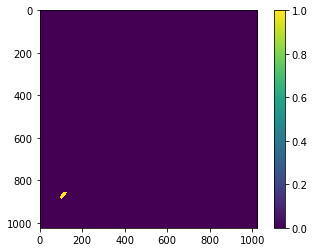

rle  876657 11 1009 17 1005 19 1004 20 1004 19 1004 19 1005 19 1003 20 1002 21 1002 22 1002 21 1002 22 1002 21 1003 21 1002 21 1003 21 1002 21 1003 20 1004 19 1005 18 1005 18 1006 17 1007 16 1008 15 1009 13 1012 11 1013 10 1014 9 1015 8 1016 7 1017 6


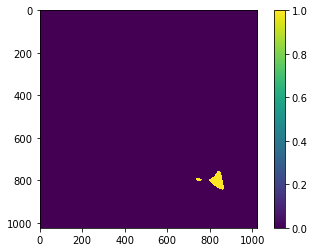


  1%|          | 9/1372 [00:14<37:06,  1.63s/it]

rle  772930 7 1016 11 1013 13 1010 15 1009 15 1009 15 1009 15 1008 16 1008 17 1006 19 1005 19 1004 21 1002 22 1001 24 999 25 998 26 997 28 996 28 995 29 995 30 994 30 994 30 995 29 995 29 995 29 994 31 992 32 991 33 989 35 987 38 983 41 980 44 909 4 65 46 907 8 62 47 906 10 59 49 906 11 56 51 905 14 53 53 903 17 49 55 902 19 46 57 901 23 42 58 901 25 39 59 901 26 38 60 901 26 36 61 902 25 36 61 902 25 36 61 903 22 38 61 904 19 39 63 906 4 5 5 41 63 961 63 962 62 963 61 964 61 964 60 965 59 966 58 967 58 967 57 968 56 969 55 970 54 970 54 972 52 973 51 974 51 974 50 975 49 977 47 978 46 979 46 979 45 980 44 981 43 983 41 984 40 986 38 988 36 990 34 991 33 993 31 994 30 995 29 996 28 1000 24 1002 22 1004 20 1005 18 1007 17 1009 14 1013 11 1018 5


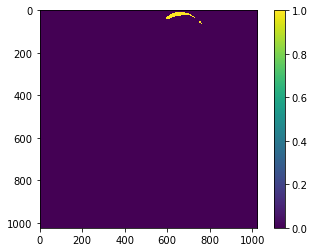

rle  9862 26 990 39 981 47 973 54 966 67 955 72 950 76 946 80 942 86 936 93 929 96 925 100 922 102 921 104 919 77 3 26 916 61 34 13 915 58 41 12 912 49 53 13 908 47 58 12 906 45 63 11 903 41 71 11 899 39 79 8 897 38 83 7 895 37 88 6 892 35 92 6 890 32 97 6 889 28 102 5 889 26 106 2 889 24 110 1 889 22 1003 18 1006 15 1010 9 11410 2 1021 5 1019 6 1018 7 1017 8 1017 8 1016 9 1016 9 1017 7 1018 7 1018 6 1019 5 1021 3 1022 1


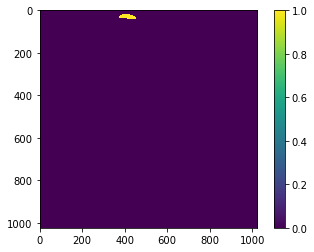

rle  19852 16 1001 31 989 40 981 46 975 53 969 58 964 63 959 67 956 70 953 73 950 75 949 76 947 78 946 79 944 82 942 83 942 82 943 81 947 78 965 58 981 42 995 27 1013 4


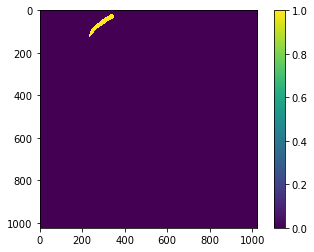

rle  21834 15 1007 18 1005 19 1004 20 1002 23 998 26 996 28 994 30 992 32 991 33 989 35 987 37 986 38 984 40 983 40 983 41 982 42 980 43 980 43 979 44 979 38 984 39 984 38 984 39 984 38 985 38 984 39 984 39 984 38 985 38 984 38 985 37 986 37 985 37 986 37 986 37 986 37 986 36 987 35 988 35 988 35 988 34 988 35 988 35 988 35 988 35 988 34 989 33 989 34 989 33 990 32 990 32 991 32 991 30 993 29 994 29 994 28 995 28 995 28 995 27 996 27 996 26 996 26 997 26 997 26 998 24 999 24 999 24 1000 23 1000 23 1000 23 1001 21 1002 21 1003 21 1002 21 1003 20 1003 21 1003 20 1003 20 1004 19 1005 18 1005 18 1006 17 1006 18 1006 17 1006 17 1007 17 1006 17 1007 16 1008 15 1008 15 1009 15 1008 15 1008 15 1009 14 1010 13 1010 13 1011 12 1012 10 1014 9 1015 8 1016 6 1018 5 1018 5 1019 4 1020 4 1020 3 1022 2


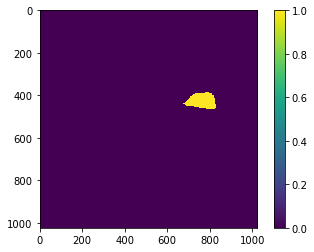


  1%|          | 10/1372 [00:15<38:01,  1.68s/it]

rle  396045 10 994 1 13 17 988 10 5 23 970 55 966 60 961 67 950 79 940 87 935 90 932 92 931 93 929 95 928 97 926 99 925 100 923 103 920 104 918 106 917 106 917 107 916 109 915 110 913 112 912 113 910 114 909 115 907 118 905 119 904 121 902 122 902 122 901 123 900 124 899 126 897 128 895 130 893 131 893 130 893 131 893 130 893 131 892 133 890 135 888 137 886 138 885 138 885 138 884 139 884 140 881 145 877 148 874 150 873 152 873 150 876 148 879 145 880 144 880 145 879 146 879 145 880 144 881 143 883 141 885 138 891 4 4 125 916 109 918 106 922 103 928 96 931 93 934 90 944 81 946 78 951 71 961 62 967 3 5 48 980 41 996 23


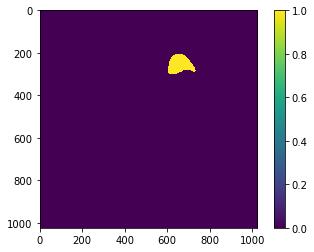

rle  210569 2 1013 22 998 28 994 34 988 39 983 43 979 47 976 50 973 53 970 55 967 59 964 61 962 63 960 65 958 68 955 70 954 72 951 74 949 76 948 77 946 79 944 81 943 82 941 84 939 85 939 86 937 87 937 88 936 88 935 90 934 90 933 92 932 94 930 95 928 97 927 98 925 99 925 100 924 101 922 103 921 104 920 105 918 107 917 108 916 109 915 110 914 111 913 112 911 114 910 114 910 114 910 115 909 115 909 116 908 116 908 116 907 118 906 118 906 119 905 120 904 121 902 122 902 123 901 123 901 124 900 124 900 125 899 125 898 127 897 127 897 127 897 128 896 128 896 128 896 129 895 129 895 88 6 35 895 78 19 33 894 75 30 25 894 73 35 22 894 71 42 17 894 69 47 14 894 66 52 12 894 64 56 9 895 62 61 5 896 58 966 56 968 55 969 53 971 52 973 49 975 48 977 43 985 37 991 31 999 17


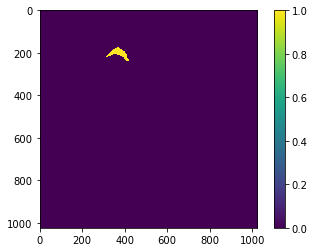

rle  180585 9 1011 15 1007 19 1003 23 999 27 995 32 991 34 988 37 985 40 982 43 980 45 978 48 974 51 972 54 969 56 967 58 964 62 961 64 960 65 958 66 957 68 954 70 954 71 952 73 950 75 948 77 946 78 945 80 943 82 941 84 939 85 939 86 937 27 16 45 935 24 22 44 934 21 27 43 932 19 32 41 931 17 40 36 930 17 44 33 930 15 48 31 929 15 51 30 927 14 54 29 927 11 58 29 925 9 63 27 925 8 66 25 925 7 70 22 924 6 75 19 923 5 79 17 1007 17 1007 18 1007 18 1006 18 1007 18 1007 17 1007 17 1007 18 1007 18 1007 17 1008 17 1009 15 1011 13 1012 12 1013 11 1014 9 1017 5


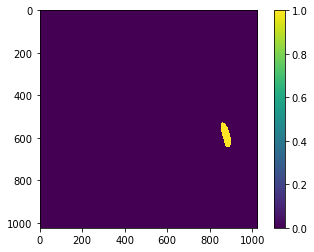

rle  541528 4 1018 11 1012 13 1011 14 1010 15 1008 17 1007 18 1006 19 1005 20 1004 21 1002 23 1001 23 1001 24 1000 25 999 25 999 25 999 26 998 26 998 27 997 28 996 28 996 29 995 29 995 30 994 30 994 30 994 31 993 31 993 32 992 32 992 33 991 33 991 33 991 34 990 34 990 34 990 34 990 35 990 34 990 35 989 35 989 35 989 36 988 36 989 36 988 36 988 36 988 36 989 36 988 36 988 36 988 37 988 36 988 36 988 37 988 36 988 36 988 36 988 37 988 36 988 36 988 36 988 36 989 36 988 36 988 36 989 35 989 36 988 36 988 36 989 35 989 35 989 35 989 36 988 36 989 35 989 35 989 35 989 35 990 34 990 34 990 34 990 34 991 33 991 33 991 33 991 33 992 32 992 32 992 32 992 32 992 32 993 31 993 31 993 31 993 31 994 29 995 29 996 28 996 28 997 27 997 27 997 27 998 26 998 26 998 25 1000 24 1000 24 1001 23 1001 23 1002 21 1003 21 1004 20 1004 19 1006 17 1010 11


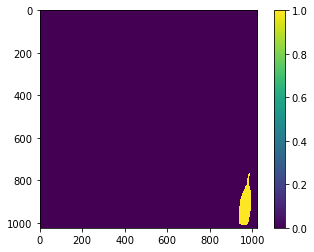


  1%|          | 11/1372 [00:17<38:09,  1.68s/it]

rle  784341 3 1021 4 1020 5 1018 6 1018 7 1016 8 1016 8 1015 9 1015 9 1015 9 1014 9 1015 9 1015 9 1015 9 1015 8 1016 8 1016 8 1015 8 1016 8 1016 8 1016 7 1017 7 1016 8 1016 8 1016 8 1015 9 1015 9 1015 9 1015 9 1014 10 1014 9 1015 9 1015 9 1015 8 1016 8 1016 7 1018 6 1018 6 1017 7 1017 7 1017 7 1017 7 1017 7 1017 7 1016 8 1016 9 1015 10 1013 12 1012 12 1012 12 1012 12 1012 12 1011 13 1011 13 1011 13 1011 13 1011 13 1010 14 1010 14 1009 15 1009 16 1007 17 1006 19 1005 19 1004 21 1003 21 1002 22 1002 23 1000 24 1000 24 999 25 999 25 999 25 999 25 998 26 998 27 997 27 996 28 996 28 995 30 993 31 993 31 992 32 992 32 991 33 991 33 990 34 990 35 988 36 988 36 987 37 987 37 987 37 986 39 985 39 984 40 984 40 983 41 983 41 982 42 982 42 982 42 981 43 981 43 981 43 980 44 980 44 980 44 980 44 979 45 979 45 979 45 978 46 978 46 977 47 977 47 977 47 976 48 976 48 975 49 975 49 975 49 975 49 974 50 974 50 974 50 974 50 974 50 974 50 974 50 974 50 973 51 973 51 973 51 973 51 973 51 973 51 973 51 97

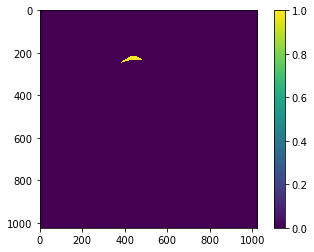

rle  221617 18 1001 26 995 32 990 37 985 41 981 44 978 47 975 50 972 55 967 60 962 64 959 65 957 68 954 71 952 73 949 75 947 78 944 81 941 39 1 4 11 29 939 36 46 2 939 33 988 29 994 25 998 21 1001 18 1005 15 1009 13 1010 11 1012 8 1014 7 1017 4 1020 2


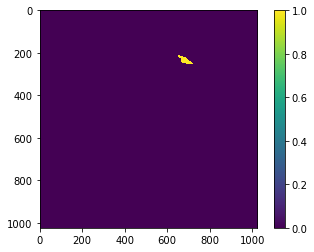

rle  218759 12 1010 16 1009 18 1007 21 1004 23 1001 25 1000 27 998 28 997 30 996 29 997 29 996 29 997 29 996 30 996 29 996 30 996 30 994 31 993 31 993 32 992 33 991 33 991 34 990 35 989 36 988 38 986 40 984 42 982 43 981 45 980 45 980 45 980 46 980 46 979 46 979 47 984 41 989 36 991 33 996 29 1006 19 1011 14 1017 6


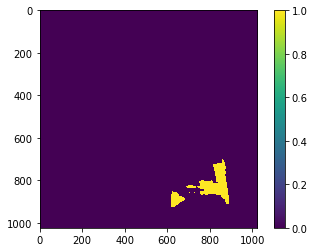


  1%|          | 12/1372 [00:18<35:17,  1.56s/it]

rle  719705 2 1021 4 1019 7 1017 7 1016 9 1015 9 1015 10 1014 10 1014 12 1012 12 1013 12 1012 13 1011 14 1009 15 1009 16 1008 16 991 3 12 18 989 10 4 21 988 36 986 38 984 40 970 8 3 43 968 56 967 57 966 59 965 59 964 60 964 60 964 60 964 60 965 59 965 59 966 59 965 59 966 58 966 58 967 57 967 57 967 57 968 56 968 56 968 56 968 56 968 56 968 55 968 56 968 56 968 56 969 54 970 54 970 54 970 54 971 53 971 54 971 53 972 52 973 52 972 52 973 51 973 51 974 50 974 50 974 50 974 50 974 50 974 50 974 50 974 49 975 49 975 49 975 49 975 48 976 48 976 49 975 49 976 48 976 48 977 48 976 48 977 48 976 48 977 47 978 46 979 46 978 46 978 46 977 47 977 47 977 47 976 48 976 47 977 47 976 48 976 48 976 48 915 2 58 49 912 6 57 49 909 11 55 50 905 15 33 4 18 49 904 18 13 7 5 12 16 49 902 21 8 29 15 50 900 23 4 33 15 49 899 62 14 49 898 63 15 48 898 64 15 48 896 65 16 47 896 66 21 41 895 67 24 38 896 66 24 39 896 66 11 51 897 67 6 54 897 127 898 127 898 126 898 126 898 126 899 126 898 126 898 126 858 2 38 1

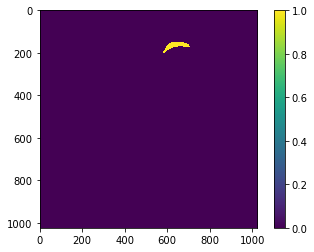

rle  153210 6 1009 24 995 48 971 61 961 67 955 73 950 77 945 81 942 84 939 86 937 88 935 91 932 94 929 96 927 98 925 100 923 102 921 104 920 105 918 107 916 108 915 59 9 42 913 52 25 34 913 46 37 28 912 42 45 25 911 40 54 19 910 38 62 11 913 35 988 33 990 32 992 29 994 28 995 26 998 24 999 24 999 23 1001 21 1002 20 1003 20 1003 19 1005 18 1005 17 1007 16 1007 15 1009 14 1009 14 1010 13 1011 12 1012 11 1012 11 1013 10 1014 8 1016 5


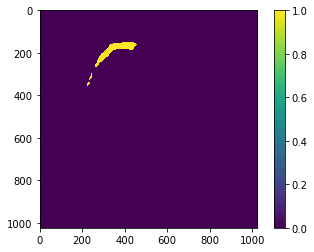


  1%|          | 13/1372 [00:19<30:47,  1.36s/it]

rle  152981 3 1017 31 991 39 970 9 2 47 962 66 942 84 939 86 921 5 10 89 916 13 4 92 910 115 906 119 903 122 900 124 899 125 898 126 897 127 897 126 897 126 897 126 898 125 898 124 900 123 900 123 901 122 901 122 902 121 902 122 902 122 901 123 900 124 899 125 898 126 896 70 14 44 895 69 19 41 893 54 4 10 26 36 893 51 53 26 892 50 59 21 894 41 70 16 896 39 76 8 900 39 80 1 903 38 985 38 985 39 984 39 984 39 984 39 984 39 984 39 983 39 984 39 983 39 984 39 983 40 983 40 983 40 983 40 983 41 983 40 983 41 983 40 983 41 982 41 982 42 982 41 982 41 982 42 981 42 982 41 982 41 983 40 983 40 984 38 985 38 986 36 987 36 988 34 989 34 989 34 990 33 991 31 992 31 992 31 993 30 993 29 995 28 995 28 996 27 996 27 997 26 998 25 999 24 999 24 1000 23 1001 21 1003 19 1005 18 1005 17 1007 16 1008 16 1007 16 1008 14 1009 14 1010 14 1009 14 1009 14 1009 15 1008 15 1008 16 1008 15 1009 15 1009 14 1010 13 1010 13 1011 12 1013 10 1014 8 1016 6 1018 5 1019 4 1021 2 1022 1 28652 1 1022 4 1019 6 1018 6 1017 

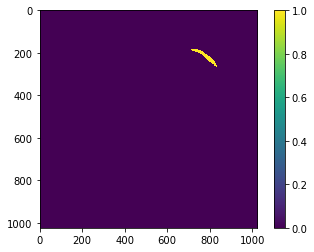

rle  189126 13 1009 35 989 38 988 39 986 41 984 42 984 42 985 41 986 40 986 40 988 38 991 35 993 32 995 31 995 30 995 29 997 28 998 28 998 27 999 26 1000 26 1000 26 1000 25 1000 26 1000 26 1000 26 999 26 999 26 1000 25 1000 25 1001 24 1001 24 1001 25 1001 24 1001 25 1000 25 1000 25 1000 25 1000 25 1000 25 1001 25 1000 25 1000 25 999 26 999 27 998 27 998 27 998 27 998 27 998 27 998 27 998 26 999 26 999 26 999 26 999 26 999 26 1000 25 1000 25 1001 23 1002 22 1003 22 1003 21 1004 21 1004 20 1005 20 1006 18 1007 18 1007 17 1009 16 1009 15 1011 13 1012 13 1012 12 1013 11 1013 12 1014 11 1014 10 1015 10 1016 8 1017 6 1019 5 1020 4


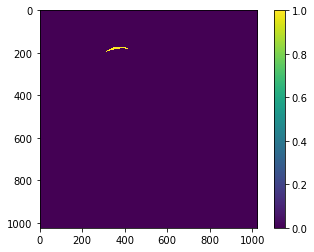

rle  178541 20 994 35 979 58 961 74 947 79 943 80 941 45 22 15 940 37 38 5 942 32 991 29 993 27 994 24 999 21 1002 20 1002 20 1002 20 1002 16 1007 13 1011 10 1013 9 1015 5


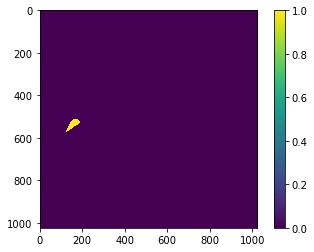

rle  521384 2 1016 11 1010 16 1006 19 1003 23 1000 25 997 27 996 29 994 31 992 32 991 34 989 36 987 38 986 39 984 41 983 41 982 43 980 44 980 44 980 44 979 45 978 45 979 45 978 45 979 44 980 43 980 43 981 42 981 42 982 41 982 40 983 39 985 37 986 36 988 34 989 34 989 33 991 31 992 30 994 29 994 28 996 27 996 26 998 25 998 24 999 23 1001 22 1001 21 1003 20 1003 20 1004 18 1005 18 1006 17 1007 15 1008 14 1010 13 1011 12 1011 12 1012 10 1014 9 1014 8 1016 6 1018 5 1018 4 1020 3 1022 1


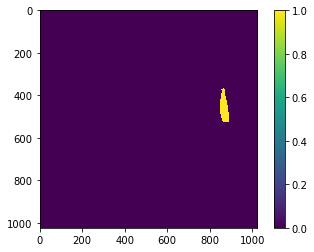


  1%|          | 14/1372 [00:21<33:30,  1.48s/it]

rle  374621 2 1022 3 1020 5 1017 8 1014 11 1012 12 1011 14 1009 16 1007 18 1006 18 1006 18 1007 17 1007 17 1007 17 1007 17 1007 17 1008 17 1007 17 1007 17 1006 18 1006 18 1006 18 1006 18 1006 18 1005 19 1005 19 1005 19 1005 19 1005 19 1005 19 1005 19 1005 19 1005 19 1005 19 1005 19 1004 20 1004 20 1004 20 1004 21 1002 22 1002 22 1002 22 1002 22 1001 24 1000 24 1000 24 999 25 999 25 999 25 999 26 998 26 998 26 998 26 998 26 997 28 996 28 996 28 996 29 995 29 995 29 994 31 993 31 993 31 993 31 993 32 991 33 992 32 992 32 992 32 992 33 991 33 991 33 991 33 991 33 990 34 990 35 989 35 989 35 989 35 988 36 988 37 987 37 987 37 987 37 988 36 988 36 988 36 988 37 987 37 987 37 987 37 987 37 987 37 987 37 987 37 986 39 985 39 985 39 985 39 985 39 985 39 985 39 985 39 985 39 985 39 985 39 985 40 984 40 985 39 985 39 985 39 985 39 985 40 984 40 985 39 985 39 985 40 984 40 984 40 984 40 985 39 985 40 984 40 984 40 984 40 985 39 985 39 985 39 985 40 984 40 985 39 985 39 985 39 985 39 986 38 986 39

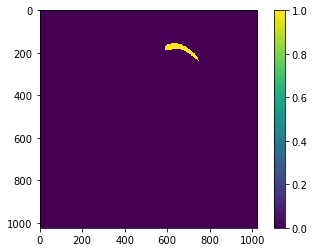

rle  160372 4 1006 34 983 45 973 56 967 61 961 67 956 70 953 73 950 75 948 78 945 81 942 84 939 88 935 91 933 93 930 95 928 97 927 98 925 100 924 102 921 104 920 106 918 108 916 110 913 112 912 114 910 115 909 51 5 8 5 48 907 48 24 46 906 33 43 44 904 27 55 39 903 22 62 38 903 18 68 37 911 7 71 36 989 36 990 35 991 34 992 33 994 31 995 30 996 30 996 29 996 29 996 29 996 29 997 28 997 27 999 27 999 26 1000 25 1001 24 1001 24 1001 23 1002 23 1002 23 1002 23 1002 23 1002 23 1002 23 1003 22 1003 21 1004 21 1005 20 1005 19 1007 17 1008 17 1008 17 1008 16 1009 16 1009 16 1009 15 1011 14 1011 13 1012 13 1013 11 1015 9 1017 7 1018 7 1018 6 1020 5 1020 4 1021 4 1022 2


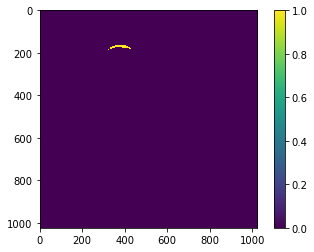

rle  167277 28 989 41 979 49 971 56 965 61 960 66 955 71 950 75 948 78 943 84 938 88 934 91 932 93 931 25 33 36 929 22 47 28 926 20 54 25 925 14 69 16 925 11 78 11 924 8 86 6 924 5 92 3 2966 3 1021 2


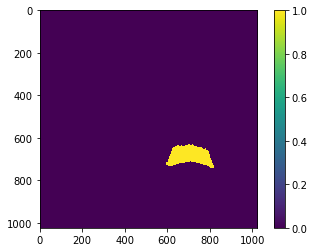

rle  642746 4 1019 5 1018 7 1017 7 1003 1 12 9 9 5 987 3 11 10 6 8 949 7 14 1 15 5 8 25 948 9 13 2 14 6 5 28 946 10 12 4 12 41 945 11 10 6 11 42 944 11 9 7 10 45 940 15 6 9 8 48 936 19 2 13 4 56 928 99 924 102 919 107 915 111 911 116 905 135 888 139 884 141 883 142 12 1 868 144 8 6 866 144 7 7 866 145 6 7 866 146 4 8 866 146 4 8 866 159 864 161 863 162 861 165 859 167 856 171 853 173 850 175 849 175 848 177 847 177 846 178 846 178 846 178 846 178 845 179 845 179 845 179 845 180 843 181 843 181 843 182 841 183 841 184 839 185 839 185 839 186 837 187 837 187 836 188 835 189 835 189 834 190 834 190 833 192 832 192 831 193 832 192 832 193 831 193 831 194 830 194 830 194 829 196 828 196 827 198 826 198 825 200 823 201 823 202 821 203 821 203 820 205 819 205 818 207 817 207 817 207 816 104 5 99 815 97 25 88 814 93 35 82 813 91 40 80 811 89 47 77 810 85 55 75 808 78 68 70 807 75 76 67 804 72 86 62 804 68 94 59 803 63 100 58 802 59 107 57 802 54 113 55 802 51 119 53 801 48 130 45 801 45 138 41

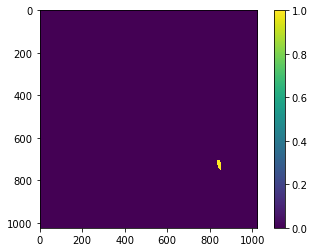


  1%|          | 15/1372 [00:23<35:15,  1.56s/it]

rle  721729 7 1015 12 1011 14 1010 15 1009 15 1008 17 1007 17 1008 17 1007 17 1007 17 1007 17 1007 18 1007 17 1007 17 1007 17 1008 16 1008 16 1009 15 1009 15 1009 15 1009 15 1009 16 1009 15 1009 15 1009 15 1009 15 1010 14 1010 14 1010 14 1010 14 1010 15 1010 14 1010 14 1010 14 1010 14 1011 13 1011 13 1012 12 1012 12 1013 11 1013 11 1014 10 1014 10 1015 8 1017 6 1020 4 1021 2


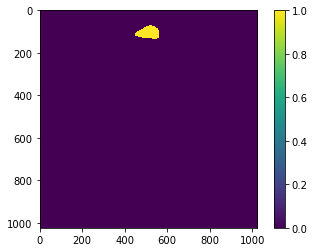


  1%|          | 16/1372 [00:23<27:47,  1.23s/it]

rle  73220 9 1009 18 1001 26 997 30 993 33 990 36 986 40 981 44 977 48 974 51 971 55 968 58 964 62 961 64 958 68 954 70 952 73 949 75 948 76 946 78 945 81 942 84 938 87 935 90 932 92 930 94 928 97 925 99 923 101 921 103 918 106 917 107 916 108 915 109 914 110 913 111 912 112 911 113 910 114 910 114 909 115 909 115 909 115 908 116 909 115 909 115 909 115 910 114 910 114 912 112 914 110 918 106 920 104 923 101 926 97 929 95 934 90 942 81 947 76 954 68 966 57 985 37 999 23


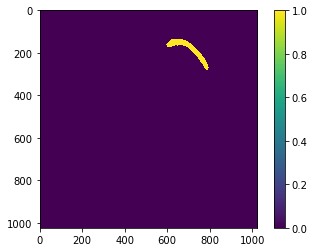

rle  138869 2 11 5 1001 38 983 45 975 55 966 63 959 68 955 72 951 74 949 77 945 81 942 84 939 87 936 90 933 92 931 95 928 98 925 100 923 103 919 107 916 109 915 110 913 112 912 113 910 115 909 116 908 118 906 119 905 121 903 122 903 123 901 55 6 64 900 40 6 4 27 48 899 37 44 45 898 35 51 41 898 32 55 40 897 28 60 40 897 24 65 38 898 13 76 38 899 9 79 38 902 2 84 37 988 37 989 36 990 35 990 35 991 34 991 34 991 33 992 33 992 33 992 33 992 32 993 32 993 32 993 32 993 32 993 32 993 32 993 32 993 32 993 32 992 32 993 32 993 32 993 32 992 33 992 33 992 34 991 33 992 33 992 33 992 33 992 33 992 33 993 32 993 32 993 31 993 32 993 32 993 32 993 32 993 32 993 32 993 32 993 32 993 31 994 31 994 30 994 31 994 30 994 31 994 30 994 31 994 31 993 32 993 32 993 31 994 31 994 30 995 30 995 29 996 29 996 29 995 29 996 29 995 30 995 30 994 30 995 30 995 29 995 30 995 29 996 28 996 28 997 28 996 28 997 27 998 27 998 26 999 26 999 25 1000 24 1001 23 1003 22 1003 21 1003 21 1004 20 1005 20 1004 20 1004 20 

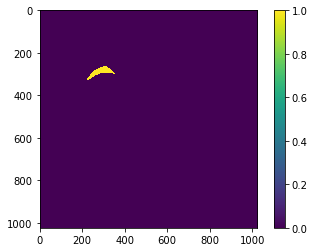

rle  270638 9 1011 17 1004 21 1000 26 995 30 991 34 987 38 983 43 979 46 975 51 971 54 968 57 965 60 961 64 958 67 955 70 953 72 950 75 948 77 945 80 943 82 940 85 938 87 936 89 934 91 931 95 928 97 926 98 925 100 923 102 921 104 919 64 7 19 3 12 918 53 31 2 9 12 916 48 51 10 914 45 57 9 912 43 63 6 911 41 982 39 985 36 987 34 990 32 991 31 992 30 994 27 996 27 996 26 998 25 998 24 999 23 1000 22 1001 21 1002 21 1003 20 1003 20 1003 19 1005 18 1006 16 1007 15 1009 13 1011 11 1012 11 1013 9 1015 8 1016 7 1017 5 1022 1


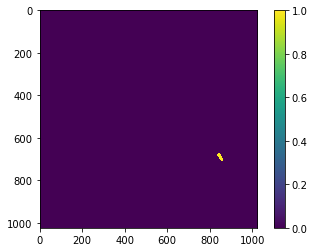


  1%|          | 17/1372 [00:25<28:26,  1.26s/it]

rle  688965 3 1020 7 1015 11 1012 14 1010 15 1008 17 1007 18 1006 18 1006 19 1005 19 1005 19 1006 19 1005 19 1006 19 1005 19 1006 19 1006 18 1007 18 1007 17 1008 17 1008 16 1008 17 1008 16 1009 15 1010 14 1010 15 1010 14 1011 13 1011 14 1011 13 1012 12 1013 11 1014 10 1015 9 1016 8 1017 7 1019 4 1023 1


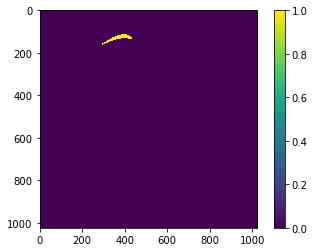

rle  117126 12 1002 30 987 41 979 47 975 51 970 56 964 62 959 67 954 72 951 74 947 78 944 81 941 84 937 88 934 90 932 93 929 95 928 97 925 99 923 48 33 21 921 43 43 16 920 40 51 11 919 38 984 36 987 34 989 32 990 32 990 31 991 30 993 28 993 28 994 27 996 25 998 23 1000 22 1000 21 1002 19 1003 19 1003 18 1004 17 1006 16 1007 15 1007 14 1009 13 1011 11 1012 9 1015 6 1018 4 1020 3


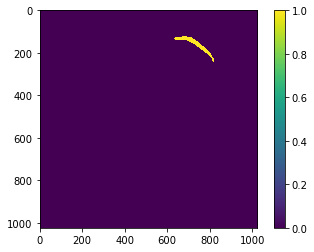


  1%|▏         | 18/1372 [00:25<25:46,  1.14s/it]

rle  127642 26 985 45 972 57 962 66 955 73 946 80 942 84 939 87 936 90 933 93 931 94 931 95 929 96 929 97 932 93 949 77 960 65 967 59 974 51 980 45 984 42 985 40 986 39 986 39 987 38 988 37 989 36 990 35 991 35 992 33 993 32 994 32 994 31 994 31 995 31 993 32 993 31 995 30 995 30 995 31 995 30 995 31 995 30 995 30 996 30 995 30 995 30 995 31 994 31 994 31 994 30 995 30 996 29 996 30 996 29 996 29 996 29 997 28 997 28 997 28 997 28 998 27 999 26 999 26 1000 25 1000 25 1000 24 1002 23 1002 23 1003 22 1003 22 1003 22 1003 22 1003 22 1003 22 1004 21 1005 20 1005 19 1006 19 1007 18 1007 18 1007 17 1008 17 1008 17 1008 17 1009 15 1010 16 1009 15 1010 15 1010 15 1010 15 1010 14 1011 14 1011 13 1012 12 1013 12 1013 12 1013 12 1012 13 1013 11 1014 11 1014 10 1014 11 1014 10 1015 9 1015 9 1016 8 1016 8 1017 7 1017 7 1017 7 1018 7 1017 7 1017 7 1018 6 1018 6 1018 6 1019 6 1018 6 1019 4 1020 4 1021 1


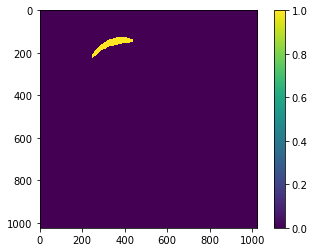

rle  130423 21 993 38 980 52 966 62 957 71 949 78 943 83 938 89 931 95 925 102 920 106 916 109 912 113 908 117 905 120 902 123 900 124 898 127 895 129 894 130 892 131 891 131 892 130 892 129 894 127 896 124 898 105 918 98 925 95 928 93 929 90 933 88 935 87 935 86 937 83 940 80 943 76 946 71 952 68 955 64 959 59 964 55 967 54 969 52 971 48 975 47 976 45 978 45 978 44 979 43 981 41 982 41 982 40 983 39 984 38 985 37 986 36 987 35 988 34 989 33 990 32 991 31 992 30 993 29 994 29 995 27 996 27 996 26 998 25 998 25 998 25 999 24 999 24 999 24 1000 22 1001 22 1001 22 1002 21 1002 21 1003 20 1003 20 1003 21 1002 21 1003 20 1003 20 1004 19 1005 18 1005 18 1006 16 1008 15 1008 15 1009 13 1011 10 1014 8 1016 6 1019 4 1020 3 1022 2


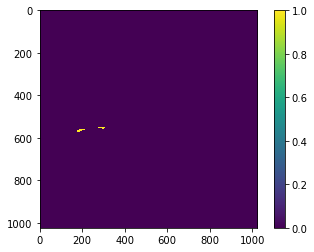

rle  561432 11 1006 29 994 31 993 32 992 32 992 34 993 31 1006 17 924 2 86 7 924 12 1005 21 998 25 996 27 994 30 992 30 992 30 993 28 995 26 998 23 1000 21 1002 18 1006 15 1008 13 1012 9 1015 6


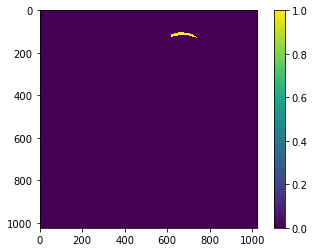


  1%|▏         | 19/1372 [00:27<26:46,  1.19s/it]

rle  108170 27 991 41 979 49 971 59 961 68 953 74 947 80 941 87 934 94 928 97 926 100 923 102 921 44 23 38 918 41 38 29 915 33 52 25 914 30 59 23 912 27 65 22 909 21 76 19 909 16 83 17 908 14 87 17 907 12 94 14 909 3 103 11 1017 7 1021 4 1021 5 1022 2


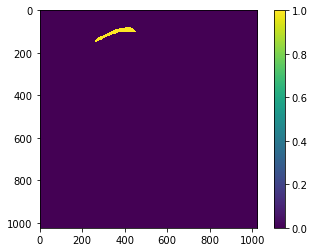

rle  83350 19 996 32 985 42 975 51 966 60 957 68 954 71 948 78 942 83 938 87 934 91 930 95 927 98 924 101 921 103 919 106 916 108 914 111 911 113 909 116 906 58 28 33 903 51 42 28 901 48 51 22 902 46 59 13 904 42 980 39 983 40 983 39 983 40 982 40 982 37 985 34 988 34 988 35 986 36 986 37 985 36 986 34 988 32 989 33 989 33 988 35 987 34 987 34 989 32 990 32 990 32 990 33 989 33 989 34 989 32 991 30 993 29 994 28 995 28 994 28 995 28 995 28 995 26 997 25 998 23 1001 21 1002 20 1004 18 1005 18 1005 16 1009 12 1012 10 1016 3


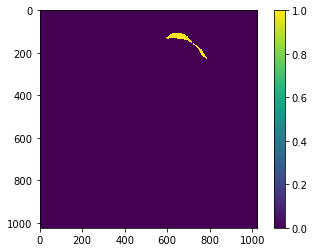


  1%|▏         | 20/1372 [00:28<24:55,  1.11s/it]

rle  109182 14 1003 30 989 39 981 45 976 50 971 56 966 60 962 65 958 68 955 71 951 74 949 77 945 80 943 83 940 86 937 89 934 91 932 92 931 94 928 97 926 99 925 99 924 101 922 103 921 104 920 105 920 18 27 60 920 12 37 55 981 44 987 38 994 31 997 28 998 28 999 26 1002 23 1004 22 1004 20 1007 18 1008 17 1008 17 1009 16 1010 15 1010 14 1012 13 1012 12 1014 10 1018 6 1020 5 1020 3 3076 2 1022 4 1020 5 1019 7 1017 9 1015 10 1016 8 1020 5 1021 6 1019 9 1016 9 1015 11 1014 11 1014 11 1014 11 1014 11 1013 12 1013 12 1013 11 1014 11 1014 11 1014 11 1015 10 1015 11 1014 12 1013 13 1012 13 1012 13 1011 13 1012 13 1011 13 1012 13 1011 13 1012 13 1011 13 1012 13 1012 13 1011 13 1012 13 1011 14 1011 13 1011 14 1010 14 1011 14 1010 14 1011 13 1011 14 1010 14 1010 15 1010 15 1010 16 1008 17 1008 17 1008 16 1009 16 1009 15 1010 14 1011 13 1012 13 1012 12 1013 11 1014 11 1014 10 1016 9 1016 10 1015 10 1015 10 1017 7 1018 6 1019 5 1020 4 1020 4 1021 3 1022 2


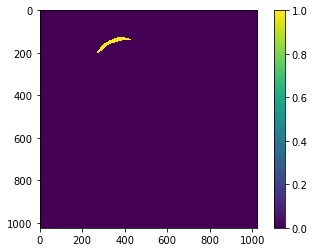

rle  132459 35 984 46 974 54 967 61 960 70 951 75 946 79 943 83 939 87 935 90 932 91 930 90 932 67 17 1 937 65 957 61 961 58 964 58 965 53 969 50 972 48 974 45 977 44 979 42 980 42 980 41 982 38 984 35 988 33 989 32 991 29 994 28 994 28 995 28 995 27 997 25 998 23 1000 22 1001 21 1002 21 1002 21 1002 21 1003 20 1003 20 1003 20 1003 20 1003 20 1003 21 1003 20 1003 20 1004 20 1003 20 1003 20 1003 20 1003 21 1002 21 1002 21 1002 22 1002 21 1002 21 1002 21 1002 21 1002 21 1002 20 1003 18 1005 16 1008 14 1010 12 1011 12 1012 11 1012 11 1013 9 1015 8 1016 6 1018 4


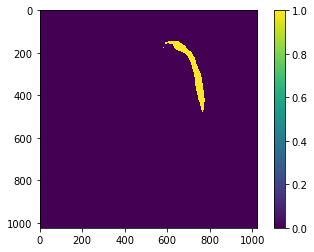

rle  148089 10 1006 21 987 40 978 49 961 65 958 68 955 70 955 70 954 71 953 73 951 74 950 75 950 75 949 8 11 57 973 53 975 50 976 50 976 50 976 50 975 51 974 52 973 52 972 53 972 53 971 54 924 1 45 54 923 2 46 54 922 2 46 55 921 3 46 55 920 3 46 55 919 4 46 56 918 4 47 56 917 4 47 57 916 4 47 58 915 4 48 58 914 4 48 59 914 2 49 60 913 2 50 60 964 61 964 60 965 60 966 58 967 58 968 56 970 55 973 52 976 50 976 51 976 50 976 50 977 49 978 47 980 45 980 44 982 42 983 42 984 5 2 33 992 33 992 32 993 32 993 31 993 32 993 32 993 31 993 32 993 32 992 32 993 32 994 31 994 30 996 29 997 28 996 28 997 28 996 29 995 29 996 29 995 30 994 30 995 30 994 30 994 31 994 30 994 30 995 29 995 30 995 29 996 28 996 29 996 28 997 27 998 27 997 27 998 26 998 27 998 26 998 26 998 27 998 26 998 26 998 26 999 25 999 26 998 26 998 26 999 25 999 26 998 26 999 25 999 25 999 26 998 26 999 25 999 26 998 26 999 26 998 26 998 26 998 27 998 26 998 26 998 27 998 26 998 27 997 27 997 27 998 27 997 27 998 27 997 27 997 27 

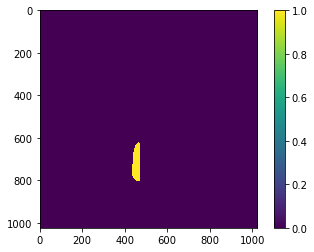


  2%|▏         | 21/1372 [00:29<26:15,  1.17s/it]

rle  636365 2 1021 5 1017 8 1015 10 1013 11 1012 12 1011 14 1009 15 1008 16 1008 16 1007 17 1007 17 1006 18 1005 19 1005 19 1004 20 1004 20 1003 21 1003 21 1003 21 1002 22 1002 22 1001 23 1001 23 1000 24 1000 24 1000 24 999 25 999 25 998 26 998 26 998 26 998 26 997 27 997 27 997 27 997 27 996 28 996 28 996 28 996 28 996 28 996 28 996 28 996 28 996 28 995 30 994 30 994 30 994 30 994 30 994 30 994 30 994 30 993 31 993 31 993 31 993 31 993 31 993 31 993 32 992 32 992 32 992 32 992 32 992 32 992 32 992 32 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 32 992 32 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 990 34 990 34 990 34 990 34 990 34 990 34 990 34 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 989 35 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 988 36 987 37 987 37 987

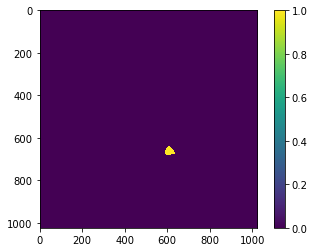

rle  655965 2 1019 7 1015 10 1013 12 1011 14 1009 17 1006 19 1005 20 1003 22 1001 24 999 26 997 28 996 29 994 31 992 33 991 34 989 36 988 37 986 39 985 40 984 41 983 42 982 42 981 44 980 44 980 44 980 45 979 45 979 45 979 46 978 46 978 46 978 46 979 45 979 45 980 43 982 40 985 31 994 22 1007 9


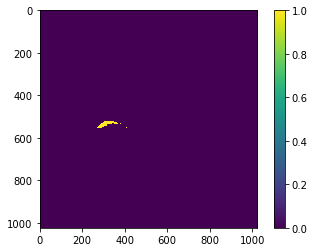

rle  533816 22 996 35 985 44 979 47 976 50 973 52 970 57 965 68 954 72 950 75 948 76 946 54 1 23 944 50 11 19 9 4 930 33 6 6 20 14 11 5 928 33 60 2 928 34 990 33 990 34 989 34 990 34 989 34 989 34 989 34 988 35 988 34 988 33 990 30 992 29 994 28 995 27 110 3 883 24 114 5 881 20 118 7 878 13 126 9 876 8 132 9 1022 1 2049 8 1018 7 1019 5 1020 3 1022 2


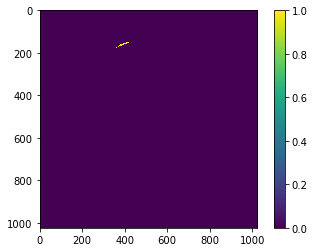

rle  155037 3 1014 13 1007 19 1001 22 997 22 1000 21 1000 23 999 21 1001 18 1004 17 1005 15 1007 15 1008 14 1008 13 1009 13 1009 13 1010 11 1012 10 1012 11 1012 9 1014 8 1014 9 1013 10 1012 11 1012 8 1015 6 1017 6 1017 5 1021 1 2040 4 1019 3


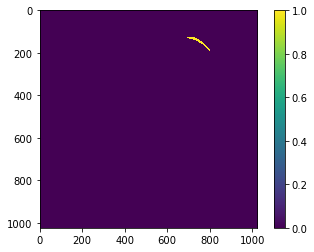


  2%|▏         | 22/1372 [00:31<29:55,  1.33s/it]

rle  128691 20 996 33 996 34 992 36 989 39 987 39 987 39 986 40 986 40 985 41 986 39 994 31 997 29 999 26 1001 25 1003 22 1005 21 1005 21 1005 20 1006 19 1007 19 1006 19 1007 19 1007 18 1007 19 1007 18 1008 17 1008 18 1008 17 1010 15 1011 14 1011 14 1012 14 1011 14 1011 14 1012 13 1012 13 1013 12 1013 12 1013 12 1013 12 1013 11 1014 11 1014 11 1015 10 1015 10 1016 10 1015 10 1015 10 1015 10 1015 10 1015 10 1014 11 1014 11 1014 11 1013 12 1013 11 1014 11 1014 10 1015 10 1015 10 1015 9 1016 9 1017 7 1018 7 1018 6 1020 4 1021 2


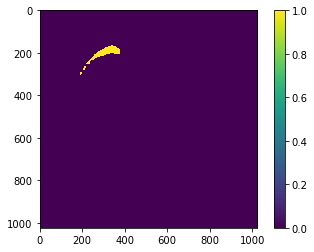

rle  170316 10 1011 16 1006 22 1000 27 995 33 987 40 979 46 976 50 972 53 970 55 967 57 966 59 963 62 959 66 956 70 951 74 947 78 945 80 943 83 939 86 937 87 936 89 933 91 931 94 928 96 926 99 923 101 921 103 920 104 919 105 918 106 916 108 915 109 913 110 913 111 911 112 911 76 3 34 910 71 12 30 910 67 19 28 909 63 27 24 909 60 43 11 909 58 49 7 909 57 966 55 968 53 970 51 972 49 975 46 977 44 979 42 981 39 984 37 985 36 987 33 989 31 992 29 995 26 997 24 1000 23 1000 22 1002 21 1002 20 1003 20 1002 21 1003 20 1004 18 1005 18 1006 16 1007 15 1009 12 1009 11 1010 11 1011 12 1011 12 1011 12 1011 13 1011 13 1010 14 1010 13 1010 14 1009 15 1008 16 1007 17 1006 17 1007 17 1007 16 1008 14 1010 13 1011 12 1013 8 1018 1 6132 3 1020 8 1016 9 1014 10 1014 10 1013 10 1014 10 1013 11 1013 10 1013 10 1014 9 1014 10 1013 10 1013 11 1012 11 1013 11 1012 12 1012 11 1013 10 1014 7 1017 6 1018 4 1020 4 1019 4 1020 4 1022 1 4088 1 1020 5 1017 7 1017 7 1016 8 1016 8 1015 9 1015 9 1015 8 1016 8 1016 7 101

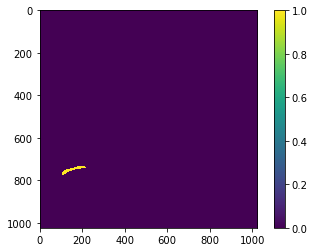

rle  750782 15 1002 29 988 37 982 45 974 52 969 55 964 57 964 57 963 59 963 54 967 52 968 51 970 49 971 48 972 45 972 44 976 44 977 43 979 42 980 40 983 38 984 37 986 35 988 34 989 33 991 31 992 30 993 28 996 26 998 25 998 24 1000 23 1001 21 1003 20 1004 18 1006 16 1008 15 1009 13 1011 11 1014 8 1017 4


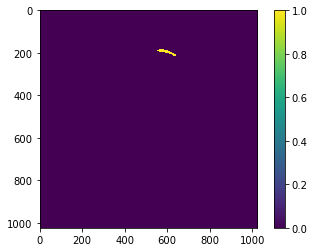

rle  188985 4 1012 22 999 28 994 33 989 39 983 45 978 48 977 50 975 52 974 53 975 51 978 49 979 47 988 38 992 34 994 32 997 28 1001 25 1002 24 1002 24 1003 23 1003 22 1004 21 1005 21 1006 19 1008 18 1007 18 1008 16 1011 14 1012 12 1014 11 1018 4


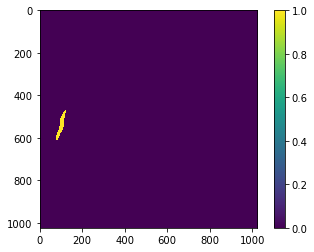


  2%|▏         | 23/1372 [00:32<32:23,  1.44s/it]

rle  481397 2 1022 3 1020 5 1018 6 1017 7 1016 8 1016 8 1015 9 1015 9 1014 9 1014 10 1013 11 1013 11 1012 11 1013 11 1012 12 1012 12 1011 13 1011 13 1010 13 1010 14 1010 14 1009 15 1008 15 1009 15 1008 16 1008 16 1007 17 1007 16 1008 16 1008 16 1007 17 1007 17 1007 17 1006 18 1006 17 1006 18 1006 18 1005 19 1005 19 1005 19 1005 19 1005 19 1005 18 1006 18 1005 19 1005 19 1005 19 1005 19 1005 19 1004 20 1004 20 1004 20 1004 20 1004 20 1004 20 1004 20 1004 19 1005 19 1005 19 1005 19 1005 19 1005 19 1005 19 1005 19 1004 20 1004 20 1004 19 1005 19 1005 19 1005 19 1005 19 1005 19 1004 20 1004 19 1005 19 1005 19 1004 20 1004 20 1004 19 1005 19 1004 20 1004 19 1005 19 1004 20 1004 20 1004 19 1005 19 1004 20 1004 19 1004 20 1004 19 1005 19 1004 19 1005 19 1004 19 1005 18 1006 18 1005 18 1006 18 1005 18 1006 18 1005 18 1006 18 1005 18 1006 18 1006 17 1007 17 1007 16 1007 17 1007 16 1008 16 1008 15 1008 16 1008 15 1008 15 1009 15 1008 15 1009 15 1009 15 1009 14 1010 14 1010 13 1011 13 1011 12 101

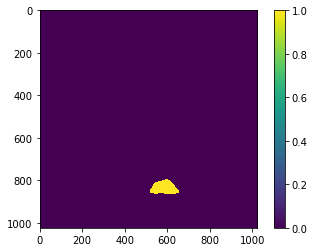

rle  815692 15 1005 21 999 26 995 31 989 36 984 41 980 46 975 51 969 56 965 61 960 65 956 68 953 72 949 75 946 79 944 81 942 83 940 85 938 87 936 89 934 91 932 93 930 95 928 97 927 98 925 99 924 101 923 102 921 103 921 104 919 105 919 106 918 107 916 108 916 109 914 111 912 113 911 115 908 117 906 119 905 119 904 121 903 121 902 123 900 125 898 127 897 128 895 130 894 131 892 133 891 133 890 135 889 135 889 135 888 137 887 137 887 137 887 138 886 138 887 137 888 136 889 135 891 134 893 131 897 114 4 9 907 18 29 7 3 7 2 36 12 4 978 3 3 22 1007 13


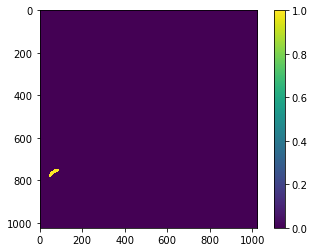

rle  766020 15 1007 23 999 26 996 27 995 29 994 30 993 30 993 29 994 29 994 29 994 29 993 29 994 29 994 28 995 27 997 25 998 24 1000 22 1001 21 1003 20 1003 19 1004 19 1004 19 1005 18 1006 17 1006 16 1008 15 1008 15 1008 15 1008 15 1009 14 1010 13 1011 12 1012 11 1014 9 1015 5


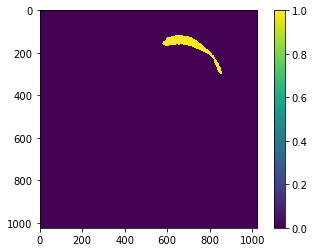

rle  122489 40 973 62 957 74 949 78 944 83 940 87 934 92 930 96 924 103 918 109 912 114 909 117 906 119 904 122 901 124 899 127 897 130 893 133 890 137 886 140 884 142 881 145 878 147 876 149 873 153 870 155 867 158 865 160 862 164 859 166 857 169 854 171 853 172 852 173 851 175 849 176 848 178 845 181 843 183 841 184 841 183 842 183 842 64 1 19 6 93 842 61 8 9 17 87 844 57 43 81 844 53 52 76 845 29 13 5 60 73 848 16 91 70 851 8 99 68 959 66 961 64 964 61 967 58 969 56 970 55 972 53 973 53 973 52 975 51 975 50 976 49 978 47 979 46 981 44 982 43 983 42 984 41 985 40 986 39 988 37 990 35 991 34 993 33 994 31 995 30 996 29 997 28 998 27 999 27 998 28 998 26 1000 25 1001 24 1001 24 1002 22 1003 22 1003 22 1004 20 1005 20 1006 18 1008 17 1009 16 1009 16 1009 17 1008 17 1008 17 1008 16 1009 15 1009 16 1010 14 1011 14 1011 13 1012 13 1012 12 1012 13 1012 12 1013 11 1014 11 1014 12 1012 14 1011 15 1010 14 1011 14 1011 13 1011 14 1011 13 1011 14 1010 14 1010 14 1010 15 1010 14 1010 14 1010 15 1

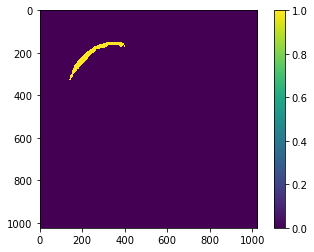


  2%|▏         | 24/1372 [00:34<34:20,  1.53s/it]

rle  151905 3 1017 13 991 49 968 60 953 75 944 83 938 88 934 91 930 95 925 100 921 104 917 107 914 110 911 113 907 118 902 91 1 30 899 70 6 14 8 29 894 69 14 7 12 20 1 8 891 55 51 17 4 6 889 55 53 16 5 7 887 54 56 15 6 6 885 55 58 12 8 6 883 56 60 10 9 7 879 58 62 8 11 6 877 59 64 4 14 7 874 60 83 7 873 59 87 4 873 57 966 55 968 52 971 47 975 43 979 41 981 41 982 39 984 36 986 31 992 29 993 30 993 30 992 31 992 32 990 33 990 33 989 35 987 36 987 36 987 36 987 36 987 36 987 36 987 35 988 34 988 33 990 32 991 32 991 31 992 31 992 32 991 32 990 33 990 34 989 34 989 34 989 35 988 35 988 35 987 37 986 37 986 37 986 37 986 37 986 37 987 36 987 36 987 36 987 36 987 36 987 36 987 37 986 37 986 37 986 37 986 38 986 37 986 37 986 38 985 38 986 37 986 37 986 37 986 37 986 37 986 38 985 38 986 37 986 37 986 37 987 36 987 36 988 35 988 35 989 34 989 34 989 34 990 34 989 34 989 34 989 34 990 33 990 33 990 33 990 32 992 31 992 31 993 30 994 29 994 29 995 28 996 27 996 27 997 26 998 25 998 25 999 25 9

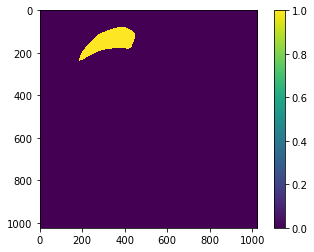

rle  82292 14 1003 34 987 41 979 47 972 55 965 61 959 68 951 75 946 81 940 87 935 91 930 96 925 101 921 105 916 110 910 116 905 120 901 124 897 128 894 131 890 135 886 139 882 143 878 147 876 149 873 152 870 154 869 155 867 157 865 159 863 162 860 164 858 166 857 167 855 169 854 170 853 171 852 172 850 174 849 175 848 176 847 177 845 179 844 180 843 181 842 182 841 183 840 184 840 184 839 185 838 186 836 188 835 189 834 190 833 190 833 191 833 191 832 192 831 193 830 194 829 195 828 196 827 197 826 197 826 198 825 198 825 199 824 199 824 200 824 199 824 200 823 201 822 201 822 202 821 203 820 203 820 203 820 204 819 204 819 205 817 206 817 207 816 207 816 208 815 209 814 210 814 210 813 211 812 211 812 212 811 213 810 213 810 214 809 214 808 216 807 216 807 215 809 161 10 42 810 143 36 33 811 135 56 18 815 130 64 12 817 122 76 6 820 115 908 111 912 102 921 99 923 99 924 98 925 97 927 89 934 84 940 81 942 79 945 76 947 75 949 73 950 72 952 71 952 70 954 67 956 66 957 65 959 63 960 61 96

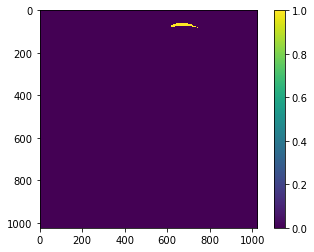

rle  61073 3 1015 27 991 42 978 51 969 59 961 68 952 75 947 80 943 83 939 88 933 94 929 97 926 100 922 104 918 110 913 50 7 56 911 38 35 42 908 27 60 30 907 21 79 19 906 17 86 17 1013 10 2052 2 1022 3


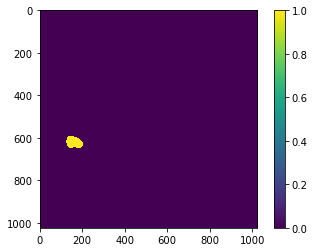

rle  605329 5 1016 14 1008 19 998 28 995 31 992 34 989 37 986 45 978 48 975 52 972 54 969 57 967 58 966 59 964 61 963 62 962 63 961 64 959 66 958 67 957 68 956 70 954 71 953 71 953 72 952 73 951 73 951 74 950 75 949 76 948 77 947 78 946 78 946 79 945 79 945 80 945 79 945 79 945 79 946 78 946 77 947 77 948 76 949 74 950 73 952 72 952 71 954 69 955 68 956 67 957 66 959 65 960 63 962 24 4 32 965 19 15 24 967 15 22 19 969 12 27 14 973 6 34 9 1021 2


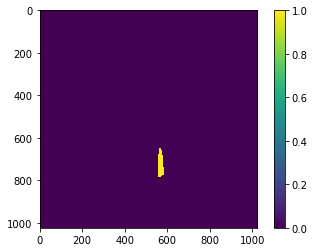


  2%|▏         | 25/1372 [00:36<35:28,  1.58s/it]

rle  661042 3 1020 5 1019 6 1017 7 1017 7 1017 8 1016 8 1015 10 1014 10 1014 11 1013 11 1013 12 1011 13 1011 13 1011 14 1010 14 1010 14 1010 14 1010 15 1008 16 1008 16 1008 17 1007 17 1007 17 1007 17 1007 17 1007 18 1006 18 1006 18 1006 18 1006 18 1006 18 1006 18 1005 19 1005 20 1004 20 1004 20 1004 20 1004 20 1003 21 1003 21 1003 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 23 1001 23 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 24 1000 25 999 25 999 25 999 25 999 25 999 25 999 25 999 25 999 25 999 25 999 25 999 25 999 25 999 25 999 25 999 26 997 27 997 27 997 27 997 27 997 27 997 27 997 27 997 27 997 27 997 27 997 27 997 27 997 27 997 28 996 28 996 28 996 28 996 28 995 29 995 29 995 29 995 29 995 29 995 29 995 30 994 30 994 30 994 30 994 30 994 30 994 30 994 30 994 30 994 30 994 31 993 31 993 31 993 31 993 31 994 30 994 30 994 30 994 30 994 30 994 30 994 30 994 30 994 30 994 29 996 28 996 27 997 25 999 23 1001 21 1003

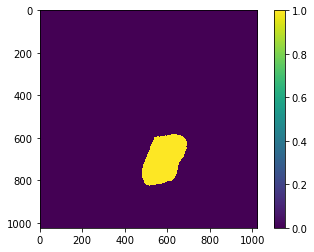

rle  598633 26 990 43 976 52 969 59 963 64 946 8 3 68 942 84 931 95 925 101 907 4 10 104 904 8 7 107 901 11 2 111 898 127 887 1 8 129 885 140 883 141 883 142 882 143 880 145 879 146 878 147 877 148 876 149 875 149 874 151 873 152 872 152 871 154 870 154 869 156 867 157 867 158 865 159 864 161 863 161 862 162 862 163 861 163 861 163 860 164 860 164 860 164 859 166 858 166 858 166 857 167 856 167 856 168 856 168 855 168 855 169 855 168 855 169 855 168 855 169 855 169 855 169 855 169 855 169 855 170 854 170 854 170 854 170 854 170 854 170 854 170 853 171 853 170 853 171 852 171 853 170 853 171 852 171 853 170 853 171 853 171 852 172 852 172 852 171 852 172 852 172 852 172 851 173 851 172 852 172 851 173 851 172 851 173 850 173 851 172 851 173 850 173 850 174 850 173 850 174 850 174 849 174 850 174 850 174 850 174 849 175 849 175 849 175 849 174 850 174 850 174 849 174 850 173 850 173 851 172 851 171 853 169 854 169 855 168 855 168 856 167 857 167 856 167 857 167 857 166 858 166 858 166 85

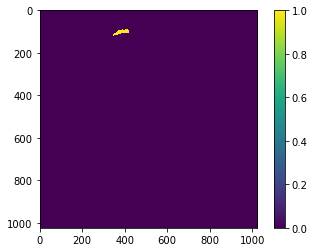

rle  93567 8 10 14 986 40 981 44 978 47 975 49 973 52 970 54 969 55 968 56 967 57 967 56 967 57 965 59 964 60 962 61 962 61 961 40 7 13 962 35 988 33 989 31 991 29 993 29 994 28 994 28 995 24 999 23 999 21 1003 15 1012 5


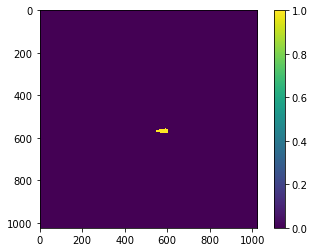

rle  569933 2 1016 12 1008 17 999 26 990 36 982 42 978 47 974 50 973 52 970 54 970 55 969 55 968 57 967 57 967 57 967 57 968 55 971 53 983 40 988 35 995 27 1007 14


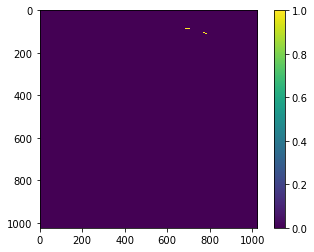


  2%|▏         | 26/1372 [00:37<36:15,  1.62s/it]

rle  87726 17 1004 21 1002 22 997 28 994 30 6 4 986 26 13375 1 1022 6 1018 10 1015 10 1017 7 1020 6 1020 8 1018 8 1020 3


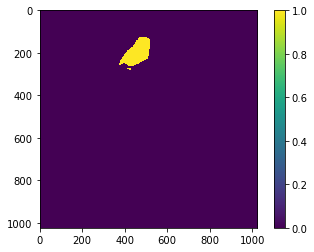

rle  129501 19 1001 26 995 31 990 37 986 40 982 43 980 46 977 48 975 51 972 52 972 53 970 55 968 57 966 58 965 60 963 61 962 63 960 64 959 65 959 65 958 67 957 67 956 68 956 68 955 69 955 69 954 70 954 71 952 72 952 72 951 73 950 74 950 74 949 74 949 75 948 76 947 77 947 77 946 78 945 79 945 79 944 80 943 81 942 82 941 83 941 82 941 83 940 84 938 86 937 87 936 87 935 89 934 90 933 91 931 92 931 93 930 93 930 94 928 96 926 97 925 99 924 100 923 101 922 102 921 103 920 103 921 103 920 104 919 105 918 106 917 107 916 108 915 109 914 109 914 110 914 110 913 111 912 112 912 112 911 113 910 114 910 114 909 114 909 115 909 115 908 116 907 117 907 117 906 118 905 119 904 119 904 120 903 121 903 121 902 121 903 121 902 122 901 122 902 122 901 123 901 122 901 123 901 123 900 123 900 121 903 119 904 118 906 115 908 112 912 110 914 109 914 109 915 107 917 103 920 101 923 100 924 98 925 98 926 97 926 96 927 95 929 92 932 91 932 91 933 90 934 17 9 64 934 15 15 59 934 14 19 56 935 12 22 52 938 10 26 

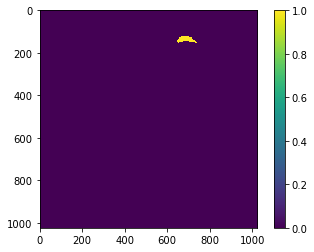

rle  125596 20 999 34 987 42 980 47 976 49 973 54 969 57 967 58 965 60 963 61 962 64 960 65 958 67 956 69 954 71 952 73 951 74 949 76 948 77 946 80 944 81 943 82 941 45 1 38 940 35 15 36 938 31 21 35 937 28 30 29 937 24 38 26 936 19 50 21 934 15 59 17 934 11 67 12 936 6 77 6 1020 4 1021 3


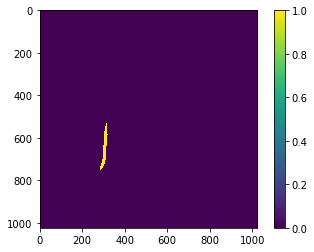

rle  542009 1 1022 3 1021 3 1020 4 1019 5 1019 5 1019 5 1018 6 1018 6 1018 6 1018 6 1017 7 1017 7 1017 7 1016 8 1015 10 1014 10 1014 10 1013 11 1013 11 1013 11 1013 11 1013 11 1012 12 1012 12 1012 13 1011 13 1011 13 1011 13 1011 13 1011 13 1011 13 1011 13 1011 13 1010 14 1010 14 1010 14 1010 14 1010 14 1010 14 1009 15 1009 15 1009 15 1009 14 1010 14 1010 14 1010 15 1009 15 1009 15 1009 15 1009 15 1009 15 1009 15 1009 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 15 1009 15 1009 15 1009 15 1009 15 1009 15 1008 16 1008 16 1008 16 1008 16 1009 15 1009 15 1009 15 1009 15 1009 15 1009 15 1009 15 1009 14 1009 15 1009 15 1009 15 1009 15 1009 15 1009 15 1009 15 1009 15 1009 15 1008 16 1008 15 1009 15 1009 15 1009 15 1009 15 1009 15 1009 14 1010 14 1010 14 1010 14 1010 13 1011 13 1010 14 1010 14 1010 14 1010 14 1009 15 1009 15 1009 15 1009 15 1008 16 1008 16 1008 16 1008 16 1008 16 1008 15 1009 15 1009 15 1009 15 1009 15 1009 14 1010 14 1009 15 1009 15 1009 15 1009 15 1009 16 1008 16 1008 16 

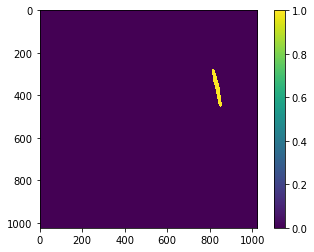


  2%|▏         | 27/1372 [00:39<37:03,  1.65s/it]

rle  283436 3 1020 5 1018 7 1017 8 1016 9 1015 9 1015 10 1014 10 1014 11 1013 12 1012 12 1012 12 1012 13 1011 13 1011 13 1011 14 1010 14 1010 14 1010 15 1009 15 1009 15 1009 16 1008 16 1008 16 1008 17 1007 17 1007 17 1008 16 1008 17 1007 17 1007 17 1008 16 1008 17 1007 17 1007 17 1007 17 1007 18 1006 18 1006 18 1006 18 1006 19 1005 19 1005 19 1005 19 1005 20 1004 20 1004 20 1004 20 1004 21 1003 21 1003 21 1004 20 1004 21 1003 21 1003 21 1003 22 1002 22 1003 21 1003 22 1002 22 1003 21 1003 22 1002 22 1003 21 1003 22 1002 22 1002 22 1002 22 1003 22 1002 22 1002 22 1002 23 1002 22 1002 22 1002 23 1002 22 1002 22 1002 23 1002 22 1002 22 1002 22 1002 23 1002 22 1002 22 1002 22 1003 21 1003 21 1003 21 1004 21 1003 21 1003 21 1003 21 1004 21 1003 21 1003 21 1003 21 1004 20 1004 20 1004 20 1004 21 1004 20 1004 20 1004 20 1004 20 1004 20 1005 19 1005 19 1005 19 1005 20 1004 20 1005 19 1005 19 1005 19 1005 19 1005 19 1005 19 1006 18 1006 18 1006 18 1006 18 1007 17 1007 17 1007 17 1007 17 1008 17

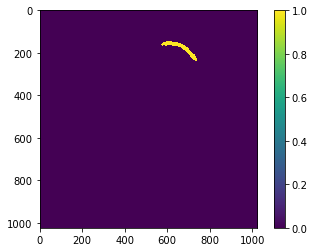

rle  150098 2 8 9 1003 30 991 44 978 51 970 59 963 65 957 69 952 74 948 77 946 80 943 84 939 88 936 91 933 93 930 96 928 99 924 102 922 31 2 72 919 28 6 73 917 13 4 10 9 73 916 6 12 6 23 63 965 61 976 50 979 46 982 43 984 41 984 41 985 40 986 39 988 38 991 34 993 33 992 33 993 32 993 32 993 31 995 30 995 30 995 29 996 29 997 28 997 27 998 27 998 26 999 26 1000 25 1000 26 999 26 1000 25 1000 25 1000 25 1000 26 999 26 999 25 999 26 999 25 1000 25 1000 26 999 26 999 26 999 26 1000 25 1000 25 1000 26 999 26 999 25 1000 25 999 26 998 27 998 27 997 28 996 29 996 28 997 27 998 27 998 26 999 25 999 26 999 25 1000 25 1000 25 1000 24 1002 22 1003 22 1004 20 1006 18 1007 17 1008 16 1011 13 1014 10 1015 10 1015 9 1022 1


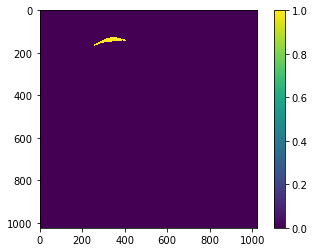

rle  131409 2 9 3 1000 36 982 48 973 54 967 63 958 70 951 77 945 82 939 89 932 98 924 102 920 105 918 106 915 110 912 112 911 95 6 12 909 93 13 9 907 92 18 7 905 58 6 18 31 5 904 56 966 47 975 37 986 34 988 28 994 26 996 26 996 26 996 21 1000 21 1001 21 1001 22 1001 20 1002 19 1003 19 1004 18 1005 16 1008 14 1009 12 1012 6


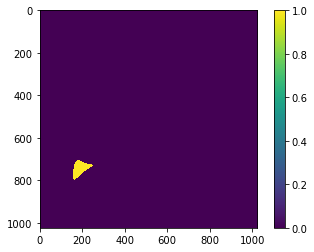

rle  721076 5 1016 10 1011 15 1008 18 1004 23 1000 26 997 28 995 30 993 32 992 33 990 35 989 37 986 40 984 42 982 44 979 48 976 51 972 57 967 62 962 72 951 76 948 80 944 83 941 84 939 86 938 86 938 86 938 86 937 86 938 85 939 84 940 82 942 81 942 80 944 79 945 77 947 75 948 74 950 73 951 71 953 70 953 70 954 69 955 67 957 66 958 64 960 63 961 61 962 61 963 60 964 59 965 57 967 55 969 54 970 53 971 52 972 51 973 50 974 48 976 47 977 45 978 45 979 44 981 42 982 41 983 40 984 39 985 38 986 37 986 36 988 35 989 34 991 32 992 32 992 31 993 30 994 29 995 28 996 27 997 25 999 24 1000 22 1002 21 1003 20 1004 19 1005 18 1006 16 1009 13 1011 11 1014 9 1015 8 1016 6 1019 4 1022 1


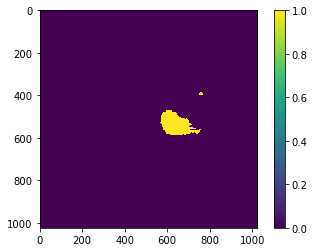


  2%|▏         | 28/1372 [00:41<37:22,  1.67s/it]

rle  396016 10 1012 12 1011 14 1009 15 1009 15 1009 16 1008 16 1008 17 1007 17 1007 17 1008 17 1007 17 1009 14 1012 11 1015 8 69464 7 8 6 1001 25 999 26 998 25 999 25 999 24 1000 24 999 27 996 30 993 33 989 37 984 44 974 54 967 61 961 64 959 67 956 69 955 70 954 71 954 70 955 69 956 68 956 69 955 69 954 71 952 73 950 75 947 79 944 81 942 84 940 85 939 86 938 87 937 89 935 91 933 94 931 94 930 95 929 97 4 5 918 108 915 110 914 113 6 4 901 125 898 127 897 128 896 129 895 129 895 130 894 130 894 131 893 132 892 132 892 132 892 133 891 133 891 133 891 133 891 133 890 134 890 135 889 135 889 135 889 136 888 138 887 142 882 144 881 144 881 145 881 144 882 143 881 143 881 142 882 140 883 139 884 134 890 130 893 130 894 28 9 92 896 27 9 92 899 126 900 125 900 135 889 138 886 140 885 150 874 153 871 154 870 153 872 152 872 150 874 148 877 143 881 141 883 125 44 5 851 124 11 7 7 10 7 8 851 128 1 43 852 172 854 169 856 167 858 166 859 164 861 163 862 162 862 162 862 162 862 162 863 161 863 118 4 

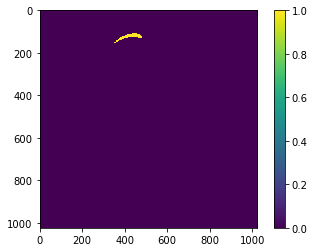

rle  112049 18 1003 25 995 33 986 42 977 49 971 54 967 59 961 65 956 71 950 75 947 78 944 82 940 85 937 88 934 90 932 93 929 97 925 99 924 100 921 102 920 36 46 21 920 31 992 25 998 23 1000 22 1000 23 1000 21 1002 18 1004 18 1004 18 1005 17 1005 17 1006 17 1005 16 1007 14 1009 13 1010 12 1012 11 1012 10 1012 10 1011 12 1011 11 1012 10 1014 7 1015 8 1015 7 1018 4


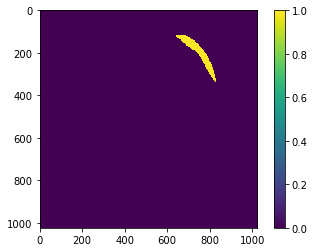

rle  119438 21 991 40 980 46 978 48 976 49 976 50 974 51 973 53 971 55 969 57 968 58 966 60 965 60 966 60 966 59 970 56 970 57 969 57 968 57 969 57 969 56 971 54 971 54 970 55 969 56 968 58 966 60 964 63 961 64 960 65 961 64 962 63 962 62 963 62 964 61 964 62 964 61 965 60 966 59 966 59 966 59 966 59 966 58 966 60 965 60 965 60 965 60 965 60 965 60 964 61 964 60 966 59 966 59 967 58 968 57 969 56 969 56 970 55 970 54 971 54 971 54 972 53 972 53 972 53 972 53 972 52 973 52 973 52 973 52 973 52 973 51 975 50 976 49 984 41 984 41 984 41 984 41 984 40 985 40 985 40 984 41 984 41 984 41 984 40 984 41 984 41 984 41 984 40 985 40 985 39 986 39 986 39 986 38 988 37 987 38 987 38 987 37 988 37 987 38 987 37 988 36 989 36 988 37 988 36 989 36 989 35 989 36 989 35 989 35 990 35 989 35 990 35 989 35 989 35 990 35 989 35 990 35 989 35 990 34 990 35 990 34 991 33 991 34 991 33 991 34 991 33 991 34 991 33 991 34 990 35 990 34 990 35 990 34 990 35 990 34 990 35 990 34 991 33 991 34 991 33 992 33 991 3

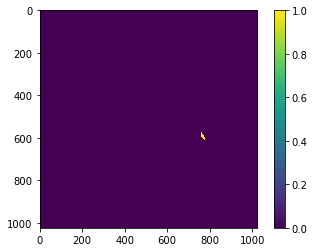


  2%|▏         | 29/1372 [00:42<34:47,  1.55s/it]

rle  587508 2 1021 4 1019 5 1019 6 1018 7 1017 8 1016 9 1015 9 1015 10 1014 11 1013 12 1012 13 1012 13 1011 13 1011 14 1011 13 1011 14 1010 15 1010 14 1010 15 1010 14 1010 14 1011 14 1011 13 1011 14 1011 13 1012 13 1012 12 1013 11 1014 10 1015 10 1015 9 1015 9 1016 8 1017 7 1017 7 1018 6 1019 5 1020 3 1022 2


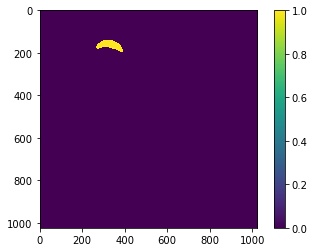

rle  142643 20 1000 29 991 37 985 42 980 47 975 53 968 58 964 62 961 66 956 70 953 73 950 76 947 79 944 81 941 85 938 87 935 91 931 94 928 98 925 100 923 102 922 104 920 105 918 107 916 109 915 109 914 111 912 113 911 114 910 115 908 116 908 117 907 117 907 118 906 28 17 74 905 27 24 68 905 26 32 61 905 24 36 59 905 22 41 57 904 17 52 51 905 14 56 50 905 12 59 48 906 10 63 46 906 7 70 41 986 39 988 36 991 33 993 31 995 30 997 27 1000 24 1002 22 1004 20 1006 18 1007 17 1009 14 1013 10 1021 2


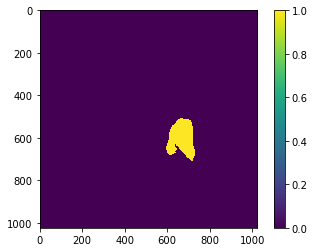

rle  521873 16 1006 22 1000 28 994 34 989 42 981 49 974 58 966 59 964 61 963 62 960 64 959 65 957 67 956 69 954 70 953 71 952 72 952 73 950 74 950 75 948 77 947 77 946 79 945 79 945 80 943 81 942 83 938 86 936 88 935 89 934 90 932 92 931 93 930 94 929 95 928 96 928 96 927 97 926 99 925 99 925 100 923 101 923 102 921 103 921 103 920 104 920 105 918 106 918 106 917 107 917 107 916 108 916 109 915 109 914 110 914 110 914 110 914 110 914 110 914 110 914 110 913 111 913 111 912 112 912 112 911 113 911 113 910 114 910 114 909 115 909 115 909 115 909 115 909 115 909 115 910 114 910 114 910 114 909 115 909 115 909 115 909 115 908 116 908 116 908 116 908 116 908 116 908 116 908 116 908 116 908 116 909 115 909 115 909 115 909 115 909 115 909 115 908 116 908 116 907 116 907 117 906 118 906 118 905 119 905 119 905 119 906 118 906 118 907 117 907 118 906 118 906 118 906 118 906 118 906 118 905 119 903 120 902 122 901 123 900 124 899 38 5 82 899 38 6 81 899 38 6 81 899 38 6 82 899 38 6 81 899 38 6 8

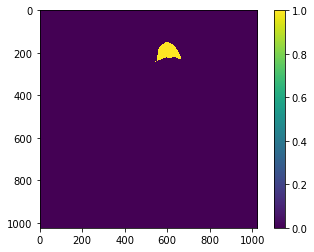

rle  154197 1 1019 9 1011 19 1003 23 1000 25 997 28 995 31 992 34 988 38 984 42 981 44 979 47 975 50 973 52 971 54 968 57 966 60 964 61 962 63 960 65 958 67 956 68 955 70 954 71 952 72 951 74 949 76 948 77 946 79 944 80 943 82 942 83 940 85 939 85 938 87 937 87 936 89 935 89 935 90 933 92 932 92 932 93 930 94 930 95 929 95 929 96 927 97 927 98 926 98 926 99 925 100 924 101 923 102 922 102 922 103 921 103 921 104 920 104 920 104 920 105 919 105 919 105 919 106 917 107 917 108 916 108 916 109 915 109 915 109 916 108 916 109 915 40 3 30 4 32 915 29 2 8 5 28 9 28 914 30 2 7 7 25 15 24 913 40 52 20 910 42 54 18 910 33 2 6 57 16 910 32 5 2 61 14 910 31 72 9 911 22 2 7 76 1 916 22 3 6 993 21 4 4 996 20 5 2 997 19 1005 9 2 8 1005 9 3 6 1006 8 1016 8 1016 7 1011 2 5 6 1011 2 6 4 1012 3 7 2 1012 2


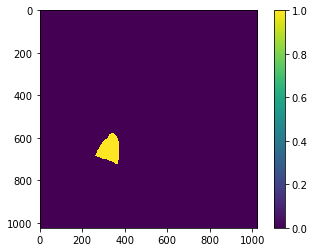


  2%|▏         | 30/1372 [00:44<36:07,  1.61s/it]

rle  593230 11 1011 16 1005 21 1002 23 1000 25 998 26 998 27 996 29 995 30 993 32 992 33 990 35 989 36 987 37 986 39 985 39 984 41 982 42 982 43 981 43 981 44 980 45 979 45 978 47 972 52 970 54 969 56 967 57 966 58 965 60 962 62 961 63 960 65 958 66 956 68 955 70 953 71 952 72 952 72 951 73 950 74 950 74 949 75 948 76 948 77 947 77 946 78 946 79 944 80 943 81 942 82 941 83 940 84 939 85 938 86 938 86 937 87 937 87 937 88 935 89 934 90 933 91 932 92 931 93 930 94 929 95 928 96 928 96 928 96 928 96 928 96 927 97 927 98 926 98 926 98 925 99 923 101 922 102 921 103 920 104 920 104 920 104 920 104 920 104 921 103 921 103 921 103 921 103 920 104 919 105 918 106 917 107 916 108 916 108 916 107 916 108 916 108 916 108 915 109 915 109 914 110 913 111 911 112 911 113 910 114 910 114 910 114 916 108 917 107 919 105 922 102 927 97 930 94 933 90 941 83 942 82 944 80 945 79 947 77 954 70 957 66 961 63 967 57 970 54 973 51 975 49 977 46 980 44 982 42 984 40 985 39 988 36 992 32 996 28 999 24 1002 22 

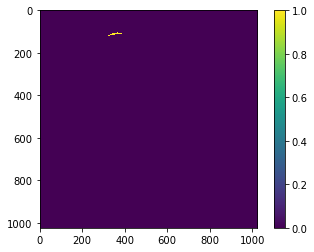

rle  107884 3 1012 25 995 30 989 37 984 42 979 44 978 43 978 44 977 42 981 36 986 23 998 14 1007 13 1007 14 1009 12 1010 6 1016 7 1016 7


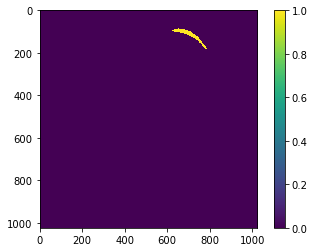

rle  88712 4 1017 23 998 29 984 45 978 50 973 54 969 58 964 62 960 67 956 71 951 76 945 82 943 83 948 78 950 77 949 5 9 63 964 62 965 60 966 59 967 58 969 57 973 52 976 49 979 47 980 45 983 43 984 41 986 40 987 39 988 37 989 36 990 35 992 34 992 33 993 32 994 32 994 31 994 31 994 31 995 31 994 31 995 30 996 28 998 27 999 26 1001 23 1003 22 1004 21 1004 20 1006 19 1006 19 1006 19 1007 17 1008 17 1009 16 1009 15 1011 14 1011 14 1011 14 1011 14 1011 14 1011 14 1010 15 1010 14 1011 14 1011 13 1012 13 1012 13 1013 12 1014 11 1014 11 1014 11 1014 11 1014 10 1015 10 1015 10 1015 10 1015 10 1014 11 1014 11 1013 11 1014 11 1014 11 1013 11 1014 11 1014 11 1014 11 1014 11 1014 11 1014 10 1015 10 1015 10 1015 9 1016 8 1017 7 1018 6 1019 5 1021 3 1022 1


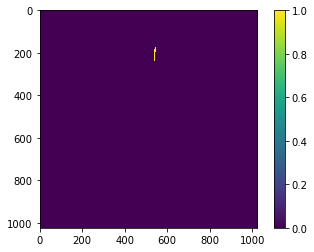


  2%|▏         | 31/1372 [00:45<33:44,  1.51s/it]

rle  180766 2 1021 5 1019 5 1019 5 1018 6 1018 6 1017 7 1017 7 1016 8 1015 8 1016 8 1016 8 1016 7 1016 8 1016 8 1016 8 1016 8 1016 7 1017 7 1017 7 1016 8 1016 8 1016 7 1017 7 1017 7 1017 7 1017 7 1017 7 1016 8 1016 8 1016 8 1016 8 1016 8 1016 8 1016 8 1016 8 1016 7 1017 7 1017 7 1018 6 1018 6 1018 6 1018 6 1018 6 1018 6 1018 6 1018 6 1018 6 1018 6 1018 6 1018 5 1020 4 1020 4 1020 4 1020 4 1020 4 1020 4 1020 4 1020 4 1020 4 1021 3 1021 3 1021 2 1022 2 1023 1


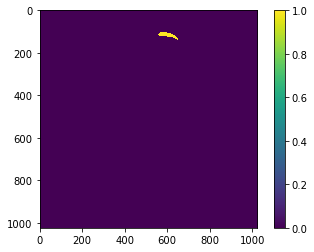

rle  107067 19 1000 31 991 37 985 42 980 49 973 54 969 58 965 62 962 64 959 67 957 69 955 72 952 74 950 76 949 76 949 77 948 78 949 77 953 72 953 72 957 2 21 45 994 31 999 26 1001 23 1003 21 1006 19 1007 18 1009 15 1011 14 1011 14 1012 12 1015 9 1018 6 1020 5 1021 2 7174 2 1023 1


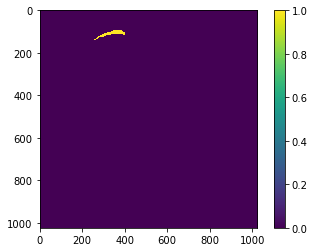

rle  94563 9 1008 24 998 29 992 36 986 43 979 48 973 52 970 56 966 59 962 64 958 67 954 71 949 76 944 82 939 85 937 88 932 92 927 98 923 101 921 66 12 25 919 65 23 17 917 61 33 13 915 55 42 12 913 46 54 11 910 39 66 8 909 37 72 6 908 34 989 29 993 26 996 26 997 26 996 27 995 27 995 27 996 22 1001 20 1003 12 5 1 1005 10 1012 11 1013 10 1013 11 1010 13 1008 15 1008 14 1010 13 1010 10 1013 8 1016 6 1018 5 1018 5 1019 5


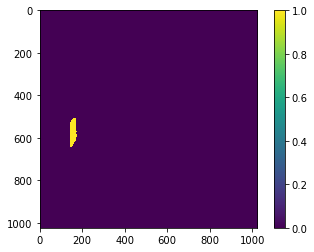


  2%|▏         | 32/1372 [00:47<32:19,  1.45s/it]

rle  518307 5 1016 9 1012 13 1009 16 1007 17 1006 18 1005 19 1003 21 1002 22 1001 23 1001 23 1000 24 999 25 999 25 998 26 998 26 998 26 997 27 997 26 998 26 998 26 997 27 997 27 997 26 998 26 997 27 997 27 997 27 997 27 996 28 996 28 996 28 996 28 996 28 996 28 996 28 995 29 995 29 995 29 995 29 995 29 995 30 994 30 994 30 994 30 994 31 993 31 993 31 993 31 993 31 993 31 992 33 991 33 991 32 992 32 992 32 992 32 992 32 992 32 992 32 992 32 992 32 992 32 992 33 991 33 991 32 992 32 992 32 992 32 992 32 992 32 992 32 992 32 992 32 992 32 992 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 33 991 32 992 32 992 32 992 32 992 32 992 32 992 31 993 31 993 31 993 30 994 30 994 30 994 30 994 29 995 29 995 29 995 29 996 28 996 27 997 27 997 26 997 26 999 25 999 24 1000 24 1000 23 1001 22 1002 22 1002 21 1003 20 1004 20 1004 19 1005 18 1006 18 1006 17 1008 15 1009 14 1010 14 1010 13 1011 12 1012 12 1012 11 1013 11 1013 10 1014 10 1014 10 1014 9 10

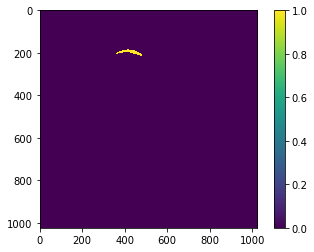

rle  189851 8 1004 29 991 38 981 47 973 55 966 61 960 67 955 73 947 80 941 85 938 88 934 92 931 95 927 31 21 48 922 26 33 45 918 21 45 42 912 21 52 41 909 19 57 40 908 14 65 38 907 9 72 37 904 8 78 35 903 5 85 32 996 29 999 26 1002 22 1006 19 1009 15 1011 12 1015 9


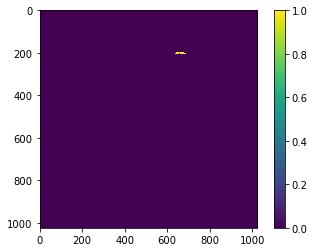

rle  200330 10 1009 20 1000 31 991 35 988 38 984 43 978 51 972 53 971 54 970 21 6 28 970 9 28 19 1012 13


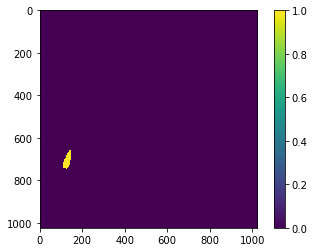


  2%|▏         | 33/1372 [00:48<31:04,  1.39s/it]

rle  671885 2 1020 4 1019 6 1018 6 1017 7 1017 7 1016 8 1015 9 1015 9 1014 10 1013 11 1012 12 1012 12 1011 13 1011 13 1010 14 1009 15 1009 15 1008 16 1007 17 1007 18 1005 19 1005 19 1004 20 1004 20 1003 21 1003 21 1002 23 1001 23 1001 23 1000 24 1000 24 999 25 999 25 999 25 998 26 998 26 997 27 997 27 997 27 996 27 997 27 996 28 996 28 995 29 995 29 994 29 995 29 994 30 994 30 994 29 994 30 994 30 994 30 993 31 993 30 994 30 993 31 993 30 993 31 993 31 993 31 993 31 992 32 992 32 992 31 993 31 993 31 992 31 993 31 993 30 994 30 994 30 994 29 995 29 995 28 996 28 996 27 997 27 997 26 999 25 999 25 999 24 1001 22 1002 21 1004 20 1005 18 1008 15 1016 6


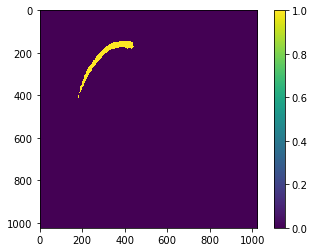

rle  147865 2 1016 12 992 38 973 58 957 70 945 80 939 86 936 89 934 91 931 94 928 96 926 98 924 101 920 104 917 107 914 111 911 113 910 114 909 116 907 117 906 118 905 119 904 120 903 121 901 123 900 124 898 127 896 128 894 130 893 131 892 132 891 71 1 60 891 64 29 40 890 58 38 37 890 53 46 33 891 50 52 12 7 10 892 48 57 7 13 5 893 45 63 2 913 42 981 39 984 37 986 35 988 34 988 34 989 33 990 33 990 32 990 33 990 33 989 34 989 34 989 34 989 34 989 34 989 34 990 32 991 32 992 30 993 30 993 29 994 29 994 28 995 28 995 28 995 28 996 27 996 27 996 27 996 27 996 28 995 28 995 28 995 28 995 28 995 28 995 28 996 28 995 28 996 27 996 28 996 27 996 27 997 27 996 27 997 26 998 26 997 26 998 25 998 25 998 25 998 24 998 25 998 25 998 25 998 25 999 23 1000 24 999 24 1000 23 1000 23 1001 22 1001 23 1001 22 1001 22 1001 23 1000 23 1000 24 1000 23 1000 24 1000 23 1000 23 1000 24 1000 23 1000 23 1000 23 1000 23 999 24 999 24 999 24 999 24 999 23 1000 23 1001 22 1002 21 1002 22 1002 21 1002 21 1003 21 10

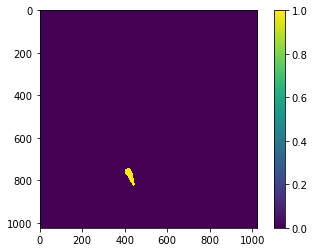

rle  760222 3 1018 8 1013 13 1010 15 1007 18 1005 20 1002 23 999 26 997 28 996 28 995 30 994 31 992 33 991 34 990 34 990 35 989 35 989 36 988 36 989 36 988 36 988 36 989 35 989 36 989 35 989 35 990 35 990 34 991 33 992 32 993 31 994 31 994 30 994 30 995 29 996 28 997 27 998 26 998 27 998 26 998 26 998 26 999 26 998 26 998 26 999 25 999 26 999 25 999 25 1000 24 1000 25 1000 24 1000 24 1001 23 1001 24 1001 23 1002 22 1003 21 1003 21 1004 20 1005 20 1004 20 1005 19 1005 19 1006 18 1007 17 1007 17 1008 16 1009 15 1009 15 1010 14 1010 15 1010 14 1011 13 1011 13 1012 12 1012 12 1013 11 1014 10 1014 10 1015 8 1017 7 1018 6 1020 3


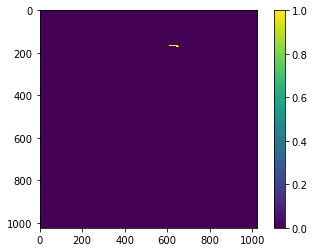

rle  168550 22 995 35 987 41 983 42 981 44 979 49 970 1 6 8 8 33 1007 17


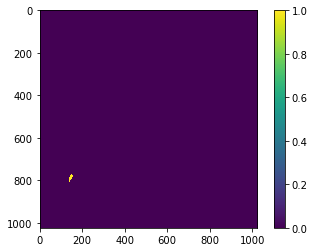


  2%|▏         | 34/1372 [00:50<33:18,  1.49s/it]

rle  789651 4 1018 7 1016 9 1014 10 1014 10 1013 11 1012 12 1012 12 1011 13 1011 13 1010 14 1010 14 1010 13 1011 13 1010 14 1010 13 1010 14 1010 13 1011 12 1011 13 1011 12 1012 11 1013 11 1013 10 1013 10 1014 10 1014 9 1015 9 1015 8 1015 9 1015 8 1016 7 1017 6 1018 6 1018 5 1019 3


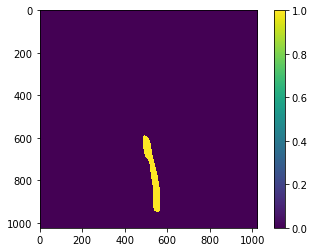

rle  602601 2 1021 5 1019 7 1016 11 1012 13 1010 15 1009 17 1006 19 1005 20 1003 22 1002 23 1001 24 1000 25 999 25 999 26 998 27 997 28 996 28 996 29 995 30 994 30 994 31 993 31 993 32 993 31 993 31 993 32 992 32 992 32 992 33 991 33 990 34 990 34 990 35 989 35 989 35 989 36 988 36 988 36 988 37 987 37 987 37 988 36 988 36 988 37 987 37 987 37 988 36 988 36 988 36 988 37 987 37 988 36 988 36 988 36 988 36 988 37 987 37 987 37 987 37 987 37 987 37 987 37 987 38 986 38 987 37 987 37 987 37 987 37 987 37 987 38 986 38 986 38 986 38 986 38 987 38 986 38 986 38 986 38 986 38 987 38 986 38 986 38 986 38 987 37 987 37 987 37 988 37 987 37 987 37 988 36 988 36 988 36 989 36 988 36 988 36 989 35 989 36 989 35 989 35 989 36 989 35 989 35 990 35 990 34 990 34 991 33 992 33 992 32 992 32 993 32 993 31 994 30 995 29 996 28 997 27 997 28 997 27 998 26 999 25 999 25 999 26 999 25 999 25 999 25 999 25 1000 25 999 25 999 25 999 26 998 26 999 25 999 26 998 26 999 25 999 26 998 26 999 25 999 25 999 25 10

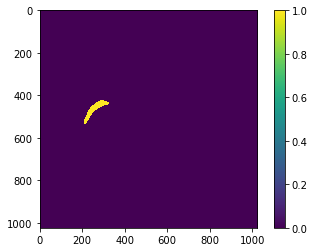

rle  433441 2 1016 14 1007 20 1001 27 996 30 992 35 988 41 981 45 976 50 972 54 969 57 966 58 965 59 964 60 963 61 962 62 960 64 959 65 958 66 956 68 955 68 955 58 964 57 966 55 968 54 968 53 970 52 971 51 972 50 973 49 974 48 975 47 976 46 977 46 977 45 978 42 982 41 982 40 983 40 983 40 983 40 984 39 984 39 985 38 985 37 986 36 988 35 988 34 990 33 990 32 991 32 992 30 993 30 994 29 994 30 994 29 994 29 995 27 997 26 997 25 999 24 999 24 1000 23 1001 23 1000 23 1001 23 1000 23 1001 23 1000 23 1001 23 1000 23 1001 22 1001 23 1001 22 1001 22 1002 22 1001 22 1002 22 1001 22 1002 22 1002 21 1002 22 1002 21 1003 21 1003 20 1003 21 1003 20 1003 21 1003 20 1004 20 1003 20 1004 20 1004 19 1004 19 1005 19 1005 18 1005 19 1005 18 1005 18 1006 18 1006 17 1007 17 1006 17 1007 17 1007 16 1008 15 1009 15 1009 14 1010 12 1012 10 1014 9 1015 7 1017 6 1018 5 1019 3 1022 1


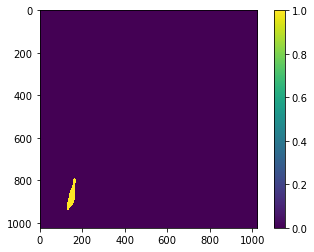

rle  810146 4 1019 6 1017 7 1016 8 1015 10 1013 11 1013 11 1013 11 1013 11 1012 12 1012 12 1012 12 1012 12 1012 12 1011 13 1011 13 1011 13 1011 12 1012 12 1012 12 1011 13 1011 13 1011 13 1011 12 1012 12 1011 13 1011 13 1011 13 1011 13 1010 14 1010 14 1010 14 1010 14 1009 15 1009 15 1009 15 1009 14 1009 15 1009 15 1009 15 1008 16 1008 16 1007 17 1007 17 1007 17 1006 18 1006 18 1005 19 1005 19 1005 19 1004 20 1004 20 1003 21 1003 21 1003 21 1002 21 1003 21 1002 22 1002 22 1002 22 1001 23 1001 23 1001 24 1000 24 999 25 999 25 999 25 998 26 998 26 998 26 997 27 997 27 997 27 996 28 996 28 996 28 996 29 995 29 994 30 994 30 994 30 994 30 994 30 993 31 993 31 993 30 994 30 993 31 993 31 993 31 993 31 992 32 992 32 992 32 992 31 993 31 992 32 992 32 992 32 992 32 992 31 992 32 992 32 992 31 993 31 993 31 992 31 993 31 993 31 993 30 993 31 993 31 993 30 994 30 994 29 995 29 995 28 996 27 996 27 997 27 997 26 998 25 999 25 999 24 1000 24 1000 23 1001 22 1002 21 1003 21 1003 20 1004 19 1004 19 1

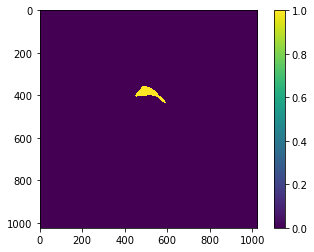


  3%|▎         | 35/1372 [00:51<34:43,  1.56s/it]

rle  366053 2 1019 17 1005 22 1001 25 998 29 994 33 990 37 987 39 984 41 983 43 980 47 976 51 972 55 968 58 965 60 963 62 961 65 958 67 956 70 953 74 950 75 948 78 945 79 944 81 942 83 941 84 939 85 938 87 936 89 934 91 933 92 931 95 928 98 925 100 923 101 922 103 921 103 920 104 919 106 918 106 917 108 916 108 915 110 914 59 14 38 912 55 26 32 911 44 41 29 910 31 61 24 909 24 71 22 907 8 7 5 77 21 907 5 93 20 1005 19 1006 19 1007 17 1009 16 1009 17 1009 16 1009 17 1008 18 1007 18 1006 19 1006 19 1006 19 1006 19 1006 19 1006 19 1006 19 1007 17 1009 15 1010 15 1010 15 1010 15 1010 15 1010 15 1010 15 1011 14 1012 13 1013 12 1014 11 1015 9 1019 5 1021 3 1023 1


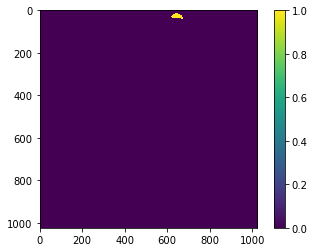

rle  15996 11 1009 18 1003 23 999 27 996 30 993 33 989 36 987 39 984 41 982 43 980 46 977 48 976 49 974 50 973 52 971 54 970 55 968 57 967 58 966 58 971 54 1001 23 1008 17 1010 14 1012 12 1017 7 1019 5


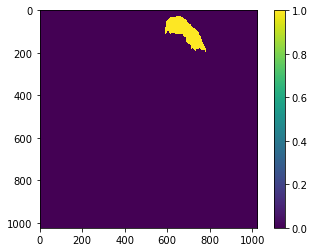


  3%|▎         | 36/1372 [00:52<30:06,  1.35s/it]

rle  31361 20 999 32 978 48 971 55 966 59 963 62 960 64 959 66 957 68 955 70 953 73 950 76 947 79 944 82 941 84 939 86 937 87 936 89 934 91 932 92 932 93 930 94 929 96 928 97 926 98 926 99 925 100 924 100 924 101 923 102 921 104 920 105 919 106 918 107 916 109 915 111 913 112 912 114 909 116 908 118 906 119 905 120 903 121 903 122 902 123 901 123 901 124 900 125 899 126 898 127 896 128 896 130 894 132 892 134 890 137 887 139 885 141 882 143 881 144 879 145 879 146 878 147 876 148 876 149 875 149 875 150 874 151 873 15 2 134 873 14 5 133 872 13 7 133 871 12 9 134 869 12 9 135 868 11 11 135 867 11 11 136 866 10 12 137 865 10 12 138 864 10 13 137 864 9 14 7 5 126 863 9 14 6 11 121 863 9 14 5 16 118 862 8 15 4 20 115 912 112 931 94 936 88 944 80 945 79 946 79 946 78 947 78 946 78 947 78 947 77 948 77 948 76 948 77 949 75 951 74 952 72 954 70 955 70 954 70 954 70 954 71 953 71 953 71 953 72 952 72 952 72 952 73 951 73 952 73 951 73 951 74 950 75 949 75 949 76 948 76 949 75 949 76 949 75 950

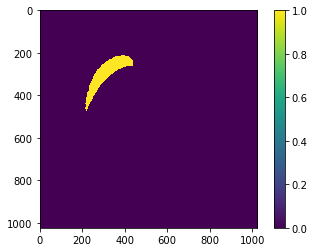

rle  217473 4 1014 22 996 34 983 44 972 56 965 60 961 65 957 68 954 71 952 73 950 75 948 76 946 79 943 83 939 86 935 91 929 96 926 100 922 103 919 106 917 108 915 110 913 112 911 113 910 114 908 117 905 119 903 121 901 123 899 126 897 127 896 128 895 130 893 131 892 132 892 132 890 134 889 135 888 136 885 139 883 141 881 143 879 145 877 147 876 147 876 148 876 148 875 148 876 147 876 147 877 137 886 129 894 125 899 120 903 116 907 114 910 111 912 111 912 110 913 110 912 110 913 110 912 107 916 103 919 101 922 99 924 98 925 98 926 96 927 96 928 96 928 94 929 94 930 93 930 92 932 90 933 89 935 87 936 87 936 86 938 85 938 85 938 85 938 85 939 84 939 84 939 83 940 83 940 82 942 80 943 80 943 80 943 79 945 79 944 79 945 78 945 78 946 77 947 75 948 75 949 74 950 73 951 72 951 72 952 71 953 70 954 69 954 69 955 68 955 68 956 66 958 65 958 64 960 63 960 63 960 63 961 62 961 62 962 61 962 62 962 61 962 61 963 60 963 60 964 59 965 57 966 57 967 56 968 55 968 55 969 54 970 53 970 53 971 52 971 53

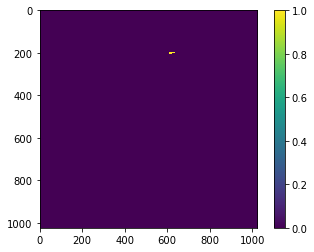


  3%|▎         | 37/1372 [00:53<27:13,  1.22s/it]

rle  201320 7 1013 22 999 26 997 27 997 25 998 24 999 20 1003 17 1007 8 4 1 1010 7 45 3 969 4 47 4


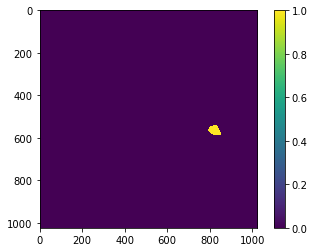

rle  551737 1 1016 10 1013 13 1009 16 1007 18 1003 22 996 29 993 32 990 34 988 37 986 39 984 40 983 42 982 42 981 44 979 46 977 47 976 49 975 49 974 51 973 51 973 52 972 52 972 52 972 53 971 53 971 53 971 54 970 54 971 53 971 53 972 53 971 53 972 53 972 52 973 51 974 51 975 49 976 48 977 47 978 47 979 45 980 44 982 43 983 41 985 38 988 36 991 33 993 30 998 23


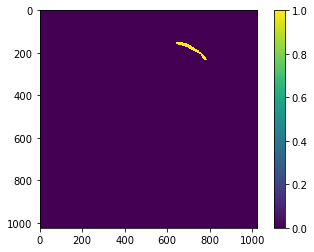

rle  154245 17 1004 26 996 32 990 39 985 42 982 45 980 47 977 50 976 50 976 51 975 51 975 52 975 51 976 49 979 47 982 43 985 41 987 38 990 36 991 35 992 34 992 34 994 31 995 31 996 30 995 30 996 29 997 29 996 30 996 30 996 29 996 30 996 30 996 29 996 29 997 29 997 28 998 28 999 26 1001 25 1001 24 1002 23 1003 22 1004 21 1004 21 1005 20 1006 19 1007 18 1009 16 1010 15 1011 14 1012 13 1013 13 1012 13 1012 13 1012 12 1013 12 1014 11 1015 10 1015 10 1014 12 1013 12 1013 12 1013 12 1012 13 1012 13 1012 13 1011 15 1010 15 1009 15 1010 15 1009 16 1009 15 1009 16 1009 16 1009 16 1009 16 1009 16 1009 15 1011 14 1011 13 1012 12 1013 11 1014 11 1014 10 1021 1


KeyboardInterrupt: 

In [32]:
test_trans = transforms.ToTensor()
sub_list = []

for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    image_id = row['ImageId']
    img_path = os.path.join(data_path, 'test_png', '{}.png'.format(image_id))
    
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    
    img = img.resize((image_size, image_size), resample=Image.BILINEAR)
    img = test_trans(img)
    
    result = model_ft([img.to(device)])[0]
    
    if len(result['masks']) > 0:
        for mask in result['masks']:
            res = transforms.ToPILImage()(mask.permute(1, 2, 0).squeeze().cpu().numpy())
            res = np.asarray(res.resize((width, height), resample=Image.BILINEAR))
            res = (res[:, :] * 255. > 127).astype(np.int8)
            
            plt.imshow(res)
            plt.colorbar()
            plt.show()
            
            rle = mask2rle(res, width, height)
            print('rle {}'.format(rle))
    else:
        print(image_id)
        rle = " -1"
        
    sub_list.append([image_id, rle])


In [12]:
sub_df = pd.DataFrame(sub_list, columns=test_df.columns.values)
sub_df.to_csv('sub.csv', index=False)


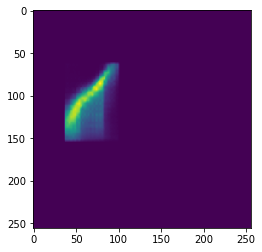

In [13]:
plt.imshow(result['masks'][0].permute(1, 2, 0).squeeze().cpu().numpy())
plt.show()